# **Predicción de Conversión de Leads Usando Random Forest**
### **Introducción**

La identificación y priorización de leads con alta probabilidad de conversión es un desafío común en marketing digital. En este notebook, abordamos este problema mediante el uso de **Random Forest**, un algoritmo clásico pero efectivo en tareas de clasificación.

El enfoque se centra en aplicar **Random Forest** para modelar la probabilidad de conversión de leads, explorando también la selección de características para mejorar la interpretabilidad y el rendimiento del modelo.

### **Objetivos del Notebook**
- Implementar un modelo de **Random Forest** para predecir la conversión de leads.
- Explorar y seleccionar las características más relevantes para el modelo mediante **RFE (Recursive Feature Elimination)**.
- Ajustar los hiperparámetros del modelo para maximizar su rendimiento.
- Evaluar la precisión y robustez del modelo con métricas clave.

### **Flujo de Trabajo**
1. **Carga y Preparación de Datos**:
   - Importar y preprocesar datos limpios desde BigQuery.
   - Realizar análisis exploratorio y selección de variables relevantes.
2. **Selección de Características**:
   - Utilizar **RFE** para reducir la dimensionalidad y mejorar el rendimiento.
3. **Entrenamiento del Modelo**:
   - Entrenar **Random Forest** y ajustar los hiperparámetros con **RandomizedSearchCV**.
4. **Evaluación**:
   - Calcular métricas como precisión, recall y F1-Score.
5. **Exportación**:
   - Guardar el modelo entrenado y preparar los datos para análisis futuros.

Este notebook proporciona una guía clara para implementar **Random Forest** de manera eficiente, destacando su versatilidad y capacidad para manejar datos complejos.


In [86]:
#Importar librerias
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import io
import os
from google.cloud import bigquery
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import precision_recall_curve
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


In [87]:
# Importar librerías necesarias
from google.cloud import storage, bigquery
import os
import pandas as pd
import io

# Configuración del bucket y credenciales
BUCKET_NAME = "tfg_credencial"
CREDENTIALS_FILE = "tfg-key.json"
#--------Linux o Mac------- Descomentar
#LOCAL_CREDENTIALS_PATH = "/tmp/credentials.json"

#--------Windows------- Descomentar
LOCAL_CREDENTIALS_PATH = r"C:\Users\DYLAN\Desktop\tfg-key.json"


# Función para descargar credenciales desde GCS
def download_credentials():
    if not os.path.exists(LOCAL_CREDENTIALS_PATH):
        client = storage.Client()
        bucket = client.bucket(BUCKET_NAME)
        blob = bucket.blob(CREDENTIALS_FILE)

        print("Descargando credenciales desde GCS...")
        blob.download_to_filename(LOCAL_CREDENTIALS_PATH)
        print("Credenciales descargadas y guardadas en:", LOCAL_CREDENTIALS_PATH)
    else:
        print("Credenciales ya existen en el sistema.")

    # Configurar credenciales en la variable de entorno
    os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = LOCAL_CREDENTIALS_PATH
    print("Credenciales configuradas en GOOGLE_APPLICATION_CREDENTIALS.")

# Llamar a la función para descargar credenciales
download_credentials()

# Inicializar el cliente de BigQuery
client = bigquery.Client()

# Nombre de la tabla en BigQuery
table_id = "future-loader-433707-h4.leads.cleaned_leads"

# Consultar los datos de la tabla
query = f"SELECT * FROM `{table_id}`"

try:
    # Ejecutar la consulta y convertir el resultado a un DataFrame
    query_job = client.query(query)
    df = query_job.result().to_dataframe()

    # Guardar el DataFrame en un archivo CSV en memoria
    memory_file = io.StringIO()
    df.to_csv(memory_file, index=False)
    memory_file.seek(0)

    # Leer el archivo en memoria nuevamente como un DataFrame
    data_frame_leads = pd.read_csv(memory_file)
    print("Tabla cargada en memoria y leída en una variable temporal (DataFrame).")
except Exception as e:
    print(f"Error al descargar la tabla: {e}")

# Configuración para mejorar la visualización del DataFrame
pd.set_option('display.max_columns', None)  # Muestra todas las columnas
pd.set_option('display.max_rows', 20)       # Número de filas (ajustable)
pd.set_option('display.width', 1000)        # Evitar saltos de línea
print(data_frame_leads.head())  # Imprimir las primeras filas formateadas


Credenciales ya existen en el sistema.
Credenciales configuradas en GOOGLE_APPLICATION_CREDENTIALS.


c:\Users\DYLAN\anaconda3\envs\entornoConda\lib\site-packages\google\cloud\bigquery\table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


Tabla cargada en memoria y leída en una variable temporal (DataFrame).
   Lead Number    Lead Origin Lead Source  Converted  Total Time Spent on Website  Page Views Per Visit Last Activity What is your current occupation  A free copy of Mastering The Interview                                 Tags               City Asymmetrique Activity Index Asymmetrique Profile Index  Asymmetrique Activity Score  Asymmetrique Profile Score Last Notable Activity  TotalVisits  Country             Specialization  Average Time Per Visit
0       619196  Lead Add Form   Reference          1                         1427                   NaN           NaN                      Unemployed                                   False                   Closed by Horizzon             Select                         NaN                        NaN                          NaN                         NaN              Modified            0  Unknown                     Select                     NaN
1       598055  Lead Ad

 # **1.Preparación del Dataset**: 

In [88]:
#Revisión general del data frame
print(data_frame_leads.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7047 entries, 0 to 7046
Data columns (total 20 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Lead Number                             7047 non-null   int64  
 1   Lead Origin                             7047 non-null   object 
 2   Lead Source                             7039 non-null   object 
 3   Converted                               7047 non-null   int64  
 4   Total Time Spent on Website             7047 non-null   int64  
 5   Page Views Per Visit                    6910 non-null   float64
 6   Last Activity                           6944 non-null   object 
 7   What is your current occupation         5171 non-null   object 
 8   A free copy of Mastering The Interview  7047 non-null   bool   
 9   Tags                                    4805 non-null   object 
 10  City                                    6438 non-null   obje

In [89]:
print(data_frame_leads.isnull().sum())

Lead Number                                  0
Lead Origin                                  0
Lead Source                                  8
Converted                                    0
Total Time Spent on Website                  0
Page Views Per Visit                       137
Last Activity                              103
What is your current occupation           1876
A free copy of Mastering The Interview       0
Tags                                      2242
City                                       609
Asymmetrique Activity Index               3160
Asymmetrique Profile Index                3160
Asymmetrique Activity Score               3160
Asymmetrique Profile Score                3160
Last Notable Activity                        0
TotalVisits                                  0
Country                                      0
Specialization                               0
Average Time Per Visit                     137
dtype: int64


In [90]:
data_frame_leads.dtypes

Lead Number                                 int64
Lead Origin                                object
Lead Source                                object
Converted                                   int64
Total Time Spent on Website                 int64
Page Views Per Visit                      float64
Last Activity                              object
What is your current occupation            object
A free copy of Mastering The Interview       bool
Tags                                       object
City                                       object
Asymmetrique Activity Index                object
Asymmetrique Profile Index                 object
Asymmetrique Activity Score               float64
Asymmetrique Profile Score                float64
Last Notable Activity                      object
TotalVisits                                 int64
Country                                    object
Specialization                             object
Average Time Per Visit                    float64


In [91]:
data_frame_leads.describe()

,Lead Number,Converted,Total Time Spent on Website,Page Views Per Visit,Asymmetrique Activity Score,Asymmetrique Profile Score,TotalVisits,Average Time Per Visit
count,7047.000000,7047.000000,7047.000000,6910.000000,3887.000000,3887.000000,7047.000000,6910.000000
mean,617690.488151,0.375337,639.468142,3.111324,14.042192,16.555184,4.448276,202.474298
std,23716.857077,0.484244,544.734632,1.955837,1.284842,1.855422,5.097278,230.185404
min,579533.000000,0.000000,1.000000,1.000000,7.000000,11.000000,0.000000,0.142857
25%,596652.500000,0.000000,173.000000,2.000000,13.000000,15.000000,2.000000,43.666667
50%,616059.000000,0.000000,404.000000,3.000000,14.000000,17.000000,4.000000,119.333333
75%,638418.500000,1.000000,1114.500000,4.000000,15.000000,18.000000,5.000000,280.512500
max,660728.000000,1.000000,2272.000000,55.000000,18.000000,20.000000,251.000000,2059.000000


In [92]:
print(data_frame_leads['Specialization'].value_counts())

print("------------------------REVISAR PORCENTAJES DE SELECT EN LA COLUMNA DE SPECIALIZATION-----------------------------")

porcentaje_select = (data_frame_leads['Specialization'] == 'Select').mean() * 100
print(f"Porcentaje de 'Select': {porcentaje_select:.2f}%")

print("------------------------------------------ANALISIS DE LA TASA DE CONVERSION----------------------------------------")

conversion_select = data_frame_leads[data_frame_leads['Specialization'] == 'Select']['Converted'].mean()
print(f"Tasa de conversión para 'Select': {conversion_select:.2f}")


Specialization
Select                               1041
Finance Management                    895
Human Resource Management             760
Marketing Management                  731
Unknown                               624
Operations Management                 467
Business Administration               373
IT Projects Management                354
Supply Chain Management               328
Banking, Investment And Insurance     304
Travel and Tourism                    199
Media and Advertising                 193
International Business                170
Healthcare Management                 139
E-COMMERCE                            107
Hospitality Management                102
Retail Management                      98
Rural and Agribusiness                 68
E-Business                             56
Services Excellence                    38
Name: count, dtype: int64
------------------------REVISAR PORCENTAJES DE SELECT EN LA COLUMNA DE SPECIALIZATION-----------------------------
Porc

Si el modelo aprende que los leads con "Select" tienen una tasa de conversión extremadamente baja, solo estará utilizando este dato como un indicador trivial y no como una característica que realmente aporte valor para predecir conversiones en general.

Esto podría derivar en un modelo que:

Detecte patrones obvios: Como "Si Specialization = Select, entonces conversión ≈ 0".
Pierda generalización: Porque el modelo no estaría aprendiendo sobre las características relevantes de los leads que realmente convierten.

In [93]:
# Eliminar filas donde 'Specialization' sea 'Select'
data_frame_leads = data_frame_leads[data_frame_leads['Specialization'] != 'Select']

# Verificar el tamaño del dataset después
print(f"Cantidad de filas después de eliminar 'Select': {len(data_frame_leads)}")


Cantidad de filas después de eliminar 'Select': 6006


In [94]:
# Verificar columnas con valores nulos
print(data_frame_leads.isnull().sum())

print("--------------COLUMNAS CON UN VALOR ALTO DE NULOS---------------")
# Analizar el porcentaje de valores nulos por columna
percent_missing = (data_frame_leads.isnull().sum() / len(data_frame_leads)) * 100
print(percent_missing)

#Analizando el volumen de nulos que tienen las columnas y viendo que no nos van  a aportar nada a los modeos de Machine Learning se van a eliminar las columnas con un 40 por ciento de valore nulos

# Eliminar columnas con más del 40% de valores nulos
columns_to_drop = percent_missing[percent_missing > 40].index
data_frame_leads.drop(columns=columns_to_drop, axis=1, inplace=True)
print(f"Columnas eliminadas: {list(columns_to_drop)}")




Lead Number                                  0
Lead Origin                                  0
Lead Source                                  2
Converted                                    0
Total Time Spent on Website                  0
Page Views Per Visit                        68
Last Activity                               49
What is your current occupation           1863
A free copy of Mastering The Interview       0
Tags                                      2015
City                                       607
Asymmetrique Activity Index               2744
Asymmetrique Profile Index                2744
Asymmetrique Activity Score               2744
Asymmetrique Profile Score                2744
Last Notable Activity                        0
TotalVisits                                  0
Country                                      0
Specialization                               0
Average Time Per Visit                      68
dtype: int64
--------------COLUMNAS CON UN VALOR ALTO DE NUL

In [95]:
# Reemplazar valores nulos en columnas categóricas y numéricas
data_frame_leads['City'].fillna('Unknown', inplace=True)
data_frame_leads['What is your current occupation'].fillna('Unknown', inplace=True)
data_frame_leads['Tags'].fillna('Unknown', inplace=True)

# Para numéricos, utilizar la media
data_frame_leads['Page Views Per Visit'].fillna(data_frame_leads['Page Views Per Visit'].mean(), inplace=True)
data_frame_leads['Last Activity'].fillna('Unknown', inplace=True)

print("Valores nulos reemplazados correctamente.")


Valores nulos reemplazados correctamente.


In [96]:
# Eliminar filas con valores nulos en columnas críticas
data_frame_leads.dropna(subset=['Lead Source'], inplace=True)
print(f"Cantidad de filas después de eliminar filas con nulos: {len(data_frame_leads)}")

#Poner la media en los pocos valores nulos que hay en la dimension Average Time Per Visit
data_frame_leads['Average Time Per Visit'].fillna(data_frame_leads['Average Time Per Visit'].mean(), inplace=True)


print("-------------------------------------VALIDAR QUE NO QUEDAN VALORES NULOS--------------------------------")

# Verificar que no quedan valores nulos
print(data_frame_leads.isnull().sum())



Cantidad de filas después de eliminar filas con nulos: 6004
-------------------------------------VALIDAR QUE NO QUEDAN VALORES NULOS--------------------------------
Lead Number                               0
Lead Origin                               0
Lead Source                               0
Converted                                 0
Total Time Spent on Website               0
Page Views Per Visit                      0
Last Activity                             0
What is your current occupation           0
A free copy of Mastering The Interview    0
Tags                                      0
City                                      0
Last Notable Activity                     0
TotalVisits                               0
Country                                   0
Specialization                            0
Average Time Per Visit                    0
dtype: int64


# **1.1 Analisis mediante graficas de cada dimension**

**LEAD ORIGIN**

In [97]:
data_frame_leads['Lead Origin'].unique()

array(['Lead Add Form', 'Lead Import', 'API', 'Landing Page Submission'],
      dtype=object)

In [98]:
data_frame_leads['Lead Origin'].value_counts()

Lead Origin
Landing Page Submission    4808
API                        1091
Lead Add Form                96
Lead Import                   9
Name: count, dtype: int64

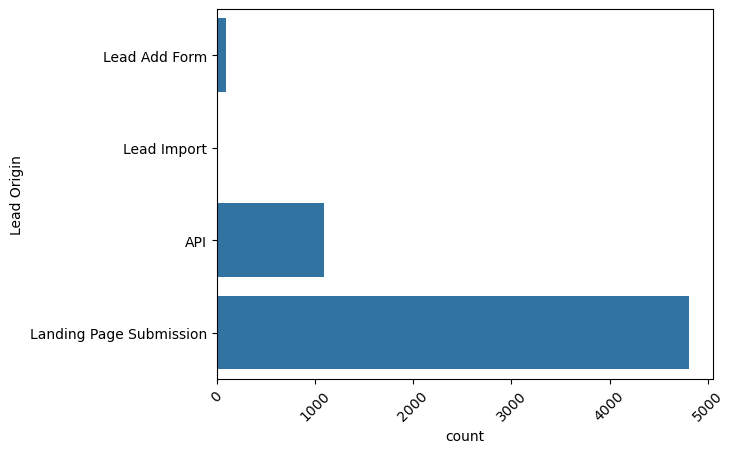

In [99]:
sns.countplot(data_frame_leads['Lead Origin'])
plt.xticks(rotation=45)
plt.show()

**Lead Source**

In [100]:
data_frame_leads['Lead Source'].unique()

array(['Reference', 'Facebook', 'Olark Chat', 'Google', 'Direct Traffic',
       'Organic Search', 'welearnblog_Home', 'Click2call',
       'youtubechannel', 'Referral Sites', 'Social Media', 'WeLearn',
       'testone', 'bing', 'Pay per Click Ads', 'Welingak Website', 'blog',
       'Press_Release', 'NC_EDM'], dtype=object)

In [101]:
data_frame_leads['Lead Source'].value_counts()

Lead Source
Direct Traffic       2454
Google               2321
Organic Search        906
Olark Chat            126
Reference              89
Referral Sites         76
Facebook                9
bing                    5
Welingak Website        5
Click2call              2
Social Media            2
Press_Release           2
welearnblog_Home        1
youtubechannel          1
WeLearn                 1
testone                 1
Pay per Click Ads       1
blog                    1
NC_EDM                  1
Name: count, dtype: int64

In [102]:
data_frame_leads['Lead Source'] = data_frame_leads['Lead Source'].fillna("Google")

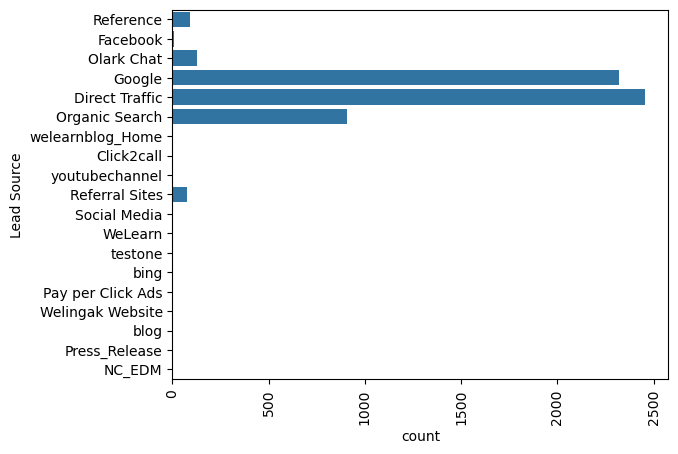

In [103]:
sns.countplot(data_frame_leads['Lead Source'])
plt.xticks(rotation=90)
plt.show()

In [104]:
#Revisando por porcentaje de distribución
LeadSourceCol=(data_frame_leads['Lead Source'].value_counts()*100)/data_frame_leads.shape[0]
LeadSourceCol

Lead Source
Direct Traffic       40.872751
Google               38.657562
Organic Search       15.089940
Olark Chat            2.098601
Reference             1.482345
Referral Sites        1.265823
Facebook              0.149900
bing                  0.083278
Welingak Website      0.083278
Click2call            0.033311
Social Media          0.033311
Press_Release         0.033311
welearnblog_Home      0.016656
youtubechannel        0.016656
WeLearn               0.016656
testone               0.016656
Pay per Click Ads     0.016656
blog                  0.016656
NC_EDM                0.016656
Name: count, dtype: float64

In [105]:
#Cargar columnas que tengan menos de 10% de los valores
LeadSourceCol=LeadSourceCol[LeadSourceCol<10]
LeadSourceCol

Lead Source
Olark Chat           2.098601
Reference            1.482345
Referral Sites       1.265823
Facebook             0.149900
bing                 0.083278
Welingak Website     0.083278
Click2call           0.033311
Social Media         0.033311
Press_Release        0.033311
welearnblog_Home     0.016656
youtubechannel       0.016656
WeLearn              0.016656
testone              0.016656
Pay per Click Ads    0.016656
blog                 0.016656
NC_EDM               0.016656
Name: count, dtype: float64

Como vemos hay muchas columnas que no nos aportan nada porque aparecen muy muy pocas veces, por lo que lo suyo es construir un dato llamado " other source" que las haga referencia a ellas.

In [106]:
for i in LeadSourceCol.index:
    data_frame_leads.loc[(data_frame_leads['Lead Source'] == i),'Lead Source']='Other Source'

In [107]:
#Revisando porcentajes de distribucion para corrobar que hemos reducido el ruido de esta columna
(data_frame_leads['Lead Source'].value_counts()*100)/data_frame_leads.shape[0]

Lead Source
Direct Traffic    40.872751
Google            38.657562
Organic Search    15.089940
Other Source       5.379747
Name: count, dtype: float64

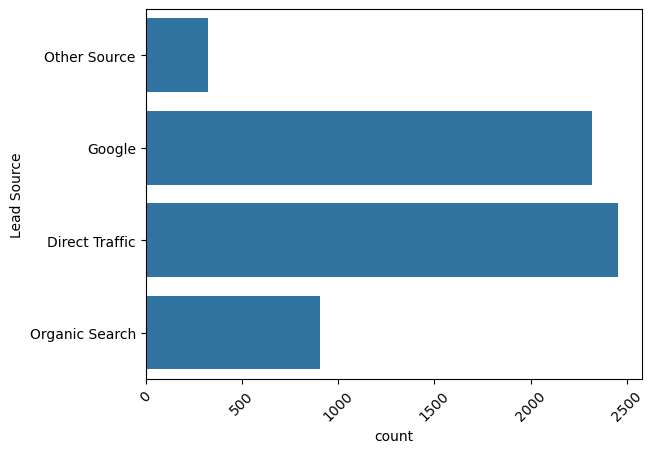

In [108]:
sns.countplot(data_frame_leads['Lead Source'])
plt.xticks(rotation=45)
plt.show()

**Last Activity**

In [109]:
data_frame_leads['Last Activity'].unique()

array(['Unknown', 'Email Bounced', 'SMS Sent', 'Olark Chat Conversation',
       'Had a Phone Conversation', 'Unreachable', 'Email Opened',
       'Unsubscribed', 'Email Link Clicked', 'Page Visited on Website',
       'Converted to Lead', 'Form Submitted on Website',
       'View in browser link Clicked', 'Email Received',
       'Approached upfront', 'Visited Booth in Tradeshow',
       'Email Marked Spam'], dtype=object)

In [110]:
data_frame_leads['Last Activity'].value_counts()

Last Activity
Email Opened                    2353
SMS Sent                        1844
Page Visited on Website          550
Converted to Lead                345
Email Bounced                    235
Olark Chat Conversation          212
Email Link Clicked               148
Form Submitted on Website        113
Unreachable                       71
Unknown                           49
Unsubscribed                      49
Had a Phone Conversation          24
View in browser link Clicked       4
Approached upfront                 3
Email Received                     2
Visited Booth in Tradeshow         1
Email Marked Spam                  1
Name: count, dtype: int64

In [111]:
#Llenamos posibles nulos con el valor mas comun en la columna Last Activity
data_frame_leads['Last Activity'] = data_frame_leads['Last Activity'].replace(np.nan, 'Email Opened')

In [112]:
data_frame_leads['Last Activity'].value_counts()

Last Activity
Email Opened                    2353
SMS Sent                        1844
Page Visited on Website          550
Converted to Lead                345
Email Bounced                    235
Olark Chat Conversation          212
Email Link Clicked               148
Form Submitted on Website        113
Unreachable                       71
Unknown                           49
Unsubscribed                      49
Had a Phone Conversation          24
View in browser link Clicked       4
Approached upfront                 3
Email Received                     2
Visited Booth in Tradeshow         1
Email Marked Spam                  1
Name: count, dtype: int64

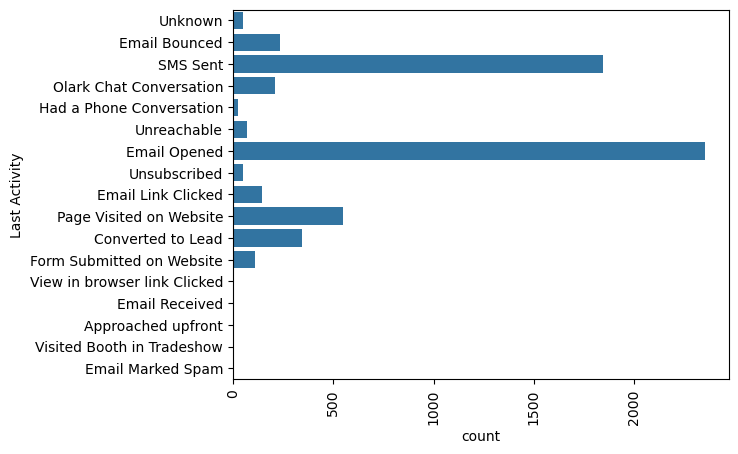

In [113]:
sns.countplot(data_frame_leads['Last Activity'])
plt.xticks(rotation=90)
plt.show()

In [114]:
#Revisando el porcentaje de distribucion de esta columna
LastActivityCol=(data_frame_leads['Last Activity'].value_counts()*100)/data_frame_leads.shape[0]
LastActivityCol

Last Activity
Email Opened                    39.190540
SMS Sent                        30.712858
Page Visited on Website          9.160560
Converted to Lead                5.746169
Email Bounced                    3.914057
Olark Chat Conversation          3.530979
Email Link Clicked               2.465023
Form Submitted on Website        1.882079
Unreachable                      1.182545
Unknown                          0.816123
Unsubscribed                     0.816123
Had a Phone Conversation         0.399734
View in browser link Clicked     0.066622
Approached upfront               0.049967
Email Received                   0.033311
Visited Booth in Tradeshow       0.016656
Email Marked Spam                0.016656
Name: count, dtype: float64

In [115]:
#Last Activity Columns having less than 5% values
LastActivityCol=LastActivityCol[LastActivityCol<5]
LastActivityCol

Last Activity
Email Bounced                   3.914057
Olark Chat Conversation         3.530979
Email Link Clicked              2.465023
Form Submitted on Website       1.882079
Unreachable                     1.182545
Unknown                         0.816123
Unsubscribed                    0.816123
Had a Phone Conversation        0.399734
View in browser link Clicked    0.066622
Approached upfront              0.049967
Email Received                  0.033311
Visited Booth in Tradeshow      0.016656
Email Marked Spam               0.016656
Name: count, dtype: float64

In [116]:
for i in LastActivityCol.index:
    data_frame_leads.loc[(data_frame_leads['Last Activity'] == i),'Last Activity']='Other Last Activity'

In [117]:
#Checking for percantage of distibution
(data_frame_leads['Last Activity'].value_counts()*100)/data_frame_leads.shape[0]

Last Activity
Email Opened               39.190540
SMS Sent                   30.712858
Other Last Activity        15.189873
Page Visited on Website     9.160560
Converted to Lead           5.746169
Name: count, dtype: float64

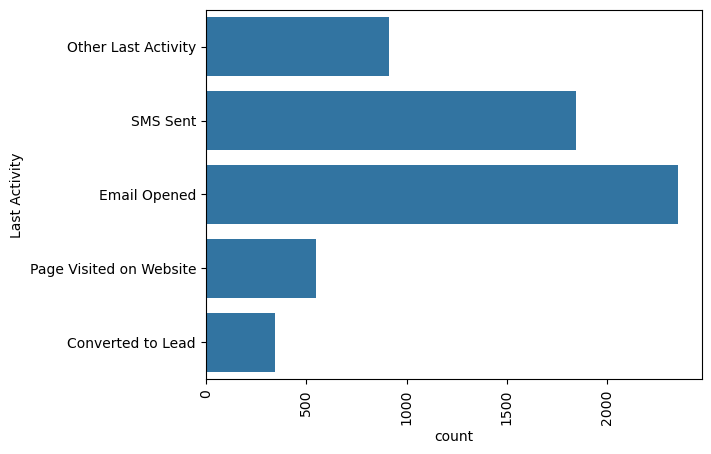

In [118]:
sns.countplot(data_frame_leads['Last Activity'])
plt.xticks(rotation=90)
plt.show()

**5.Country**

In [119]:
data_frame_leads['Country'].unique()

array(['Unknown', 'India', 'United States', 'United Kingdom', 'Australia',
       'Kenya', 'Saudi Arabia', 'Malaysia', 'United Arab Emirates',
       'Uganda', 'Canada', 'Tanzania', 'Italy', 'Qatar', 'France',
       'Bahrain', 'Oman', 'Ghana', 'unknown', 'Bangladesh', 'Singapore',
       'Kuwait', 'South Africa', 'Vietnam', 'Switzerland', 'Philippines',
       'China', 'Germany', 'Hong Kong', 'Belgium', 'Nigeria', 'Denmark',
       'Indonesia', 'Netherlands', 'Liberia', 'Asia/Pacific Region',
       'Sweden', 'Russia'], dtype=object)

In [120]:
data_frame_leads['Country'].value_counts()

Country
India                   5594
Unknown                  153
United States             61
United Arab Emirates      47
Saudi Arabia              20
                        ... 
Uganda                     1
Liberia                    1
Malaysia                   1
Kenya                      1
Russia                     1
Name: count, Length: 38, dtype: int64

In [121]:
#Los valores Na se sustituyen por el dato que mas aparece en este caso India
data_frame_leads['Country'] = data_frame_leads['Country'].fillna("India")

In [122]:
data_frame_leads['Country'].unique()

array(['Unknown', 'India', 'United States', 'United Kingdom', 'Australia',
       'Kenya', 'Saudi Arabia', 'Malaysia', 'United Arab Emirates',
       'Uganda', 'Canada', 'Tanzania', 'Italy', 'Qatar', 'France',
       'Bahrain', 'Oman', 'Ghana', 'unknown', 'Bangladesh', 'Singapore',
       'Kuwait', 'South Africa', 'Vietnam', 'Switzerland', 'Philippines',
       'China', 'Germany', 'Hong Kong', 'Belgium', 'Nigeria', 'Denmark',
       'Indonesia', 'Netherlands', 'Liberia', 'Asia/Pacific Region',
       'Sweden', 'Russia'], dtype=object)

In [123]:
data_frame_leads['Country'].value_counts()

Country
India                   5594
Unknown                  153
United States             61
United Arab Emirates      47
Saudi Arabia              20
                        ... 
Uganda                     1
Liberia                    1
Malaysia                   1
Kenya                      1
Russia                     1
Name: count, Length: 38, dtype: int64

In [124]:
# borramos la columna country porque solo  hay datos de la india y ademas el otro volumen mas cuantioso es desconocido
data_frame_leads.drop(labels='Country',axis=1,inplace=True)

**6.Specialization**

In [125]:
data_frame_leads['Specialization'].unique()

array(['Hospitality Management', 'Human Resource Management',
       'Operations Management', 'Finance Management',
       'Marketing Management', 'Supply Chain Management',
       'Travel and Tourism', 'International Business', 'Unknown',
       'Healthcare Management', 'Business Administration',
       'Banking, Investment And Insurance', 'Media and Advertising',
       'E-COMMERCE', 'IT Projects Management', 'Rural and Agribusiness',
       'E-Business', 'Retail Management', 'Services Excellence'],
      dtype=object)

In [126]:
data_frame_leads['Specialization'] = data_frame_leads['Specialization'].replace(np.nan, 'Others')

In [127]:
data_frame_leads['Specialization'].value_counts()

Specialization
Finance Management                   894
Human Resource Management            760
Marketing Management                 731
Unknown                              624
Operations Management                467
Business Administration              373
IT Projects Management               354
Supply Chain Management              328
Banking, Investment And Insurance    304
Travel and Tourism                   199
Media and Advertising                193
International Business               170
Healthcare Management                139
E-COMMERCE                           106
Hospitality Management               102
Retail Management                     98
Rural and Agribusiness                68
E-Business                            56
Services Excellence                   38
Name: count, dtype: int64

In [128]:
#Checking for percantage of distibution
OtherCol=(data_frame_leads['Specialization'].value_counts()*100)/data_frame_leads.shape[0]
OtherCol

Specialization
Finance Management                   14.890073
Human Resource Management            12.658228
Marketing Management                 12.175217
Unknown                              10.393071
Operations Management                 7.778148
Business Administration               6.212525
IT Projects Management                5.896069
Supply Chain Management               5.463025
Banking, Investment And Insurance     5.063291
Travel and Tourism                    3.314457
Media and Advertising                 3.214524
International Business                2.831446
Healthcare Management                 2.315123
E-COMMERCE                            1.765490
Hospitality Management                1.698867
Retail Management                     1.632245
Rural and Agribusiness                1.132578
E-Business                            0.932712
Services Excellence                   0.632911
Name: count, dtype: float64

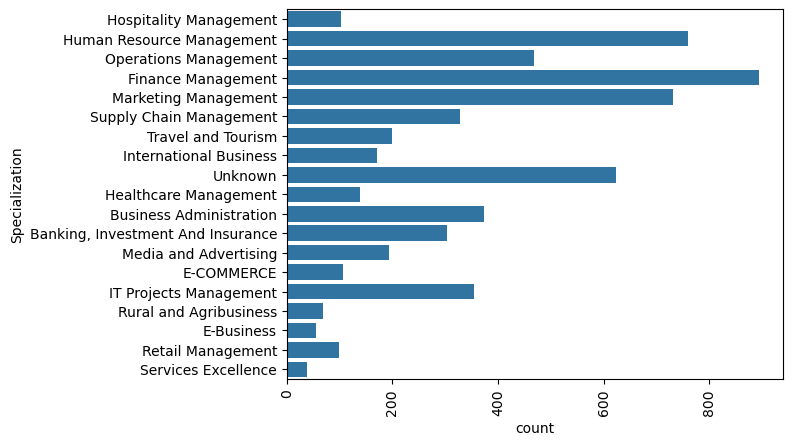

In [129]:
sns.countplot(data_frame_leads['Specialization'])
plt.xticks(rotation=90)
plt.show()

In [130]:
#Agrupamos los datos en una sola variable llamada Others cuando tienen un volumen inferior al 2% respecto a el volumen total de la columna Specialization

OtherCol=OtherCol[OtherCol<2]
for i in OtherCol.index:
    data_frame_leads.loc[(data_frame_leads['Specialization'] == i),'Specialization']='Others'
#Checking for percantage of distibution
(data_frame_leads['Specialization'].value_counts()*100)/data_frame_leads.shape[0]


Specialization
Finance Management                   14.890073
Human Resource Management            12.658228
Marketing Management                 12.175217
Unknown                              10.393071
Others                                7.794803
Operations Management                 7.778148
Business Administration               6.212525
IT Projects Management                5.896069
Supply Chain Management               5.463025
Banking, Investment And Insurance     5.063291
Travel and Tourism                    3.314457
Media and Advertising                 3.214524
International Business                2.831446
Healthcare Management                 2.315123
Name: count, dtype: float64

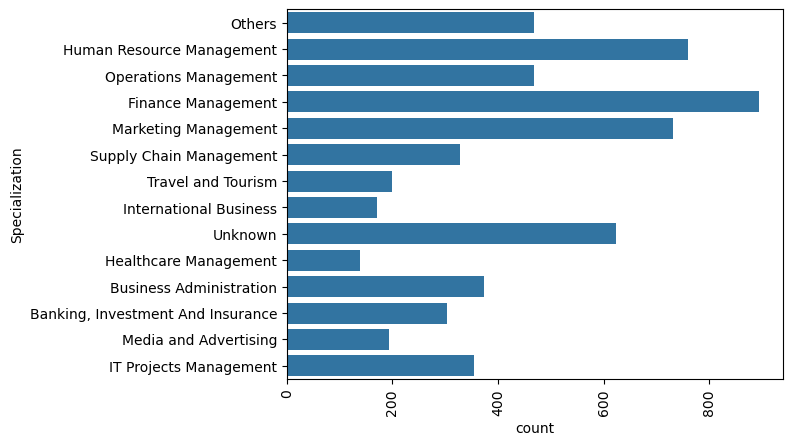

In [131]:
sns.countplot(data_frame_leads['Specialization'])
plt.xticks(rotation=90)
plt.show()

**7. WHAT IS YOUR CURRENT OCCUPATION**

In [132]:
data_frame_leads['What is your current occupation'].unique()

array(['Working Professional', 'Unemployed', 'Other', 'Housewife',
       'Unknown', 'Student', 'Businessman'], dtype=object)

In [133]:
data_frame_leads['What is your current occupation'].value_counts()

What is your current occupation
Unemployed              3504
Unknown                 1863
Working Professional     491
Student                  119
Other                     14
Housewife                  8
Businessman                5
Name: count, dtype: int64

In [134]:
data_frame_leads['What is your current occupation'] = data_frame_leads['What is your current occupation'].fillna("Unemployed")

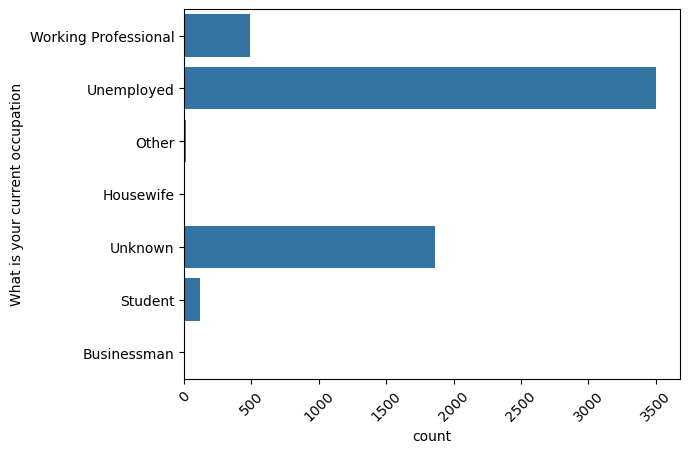

In [135]:
sns.countplot(data_frame_leads['What is your current occupation'])
plt.xticks(rotation=45)
plt.show()

In [136]:
#Revisando porcentaje de distribucion
LeadSourceCol=(data_frame_leads['What is your current occupation'].value_counts()*100)/data_frame_leads.shape[0]
LeadSourceCol

What is your current occupation
Unemployed              58.361093
Unknown                 31.029314
Working Professional     8.177881
Student                  1.982012
Other                    0.233178
Housewife                0.133245
Businessman              0.083278
Name: count, dtype: float64

**8. TAGS**

In [137]:
data_frame_leads['Tags'].unique()


array(['Will revert after reading the email', 'Lost to EINS',
       'Closed by Horizzon', 'Interested in other courses', 'Ringing',
       'Unknown', 'Interested  in full time MBA', 'Busy',
       'Already a student', 'switched off',
       'Diploma holder (Not Eligible)', 'Lost to Others',
       'invalid number', 'Graduation in progress',
       'Not doing further education', 'wrong number given', 'opp hangup',
       'number not provided', 'Interested in Next batch',
       'Want to take admission but has financial problems',
       'Still Thinking', 'in touch with EINS',
       'In confusion whether part time or DLP',
       'Shall take in the next coming month', 'University not recognized',
       'Recognition issue (DEC approval)'], dtype=object)

In [138]:
data_frame_leads['Tags'].value_counts()

Tags
Unknown                                              2014
Will revert after reading the email                  1445
Ringing                                               864
Already a student                                     283
Interested in other courses                           268
                                                     ... 
Want to take admission but has financial problems       3
In confusion whether part time or DLP                   3
Shall take in the next coming month                     1
University not recognized                               1
Recognition issue (DEC approval)                        1
Name: count, Length: 26, dtype: int64

In [139]:
#"Will revert after reading the email" is coming the most times , hence replacing NaN value with value this.
data_frame_leads['Tags'] = data_frame_leads['Tags'].fillna("Will revert after reading the email")

In [140]:
data_frame_leads['Tags'].value_counts()

Tags
Unknown                                              2014
Will revert after reading the email                  1445
Ringing                                               864
Already a student                                     283
Interested in other courses                           268
                                                     ... 
Want to take admission but has financial problems       3
In confusion whether part time or DLP                   3
Shall take in the next coming month                     1
University not recognized                               1
Recognition issue (DEC approval)                        1
Name: count, Length: 26, dtype: int64

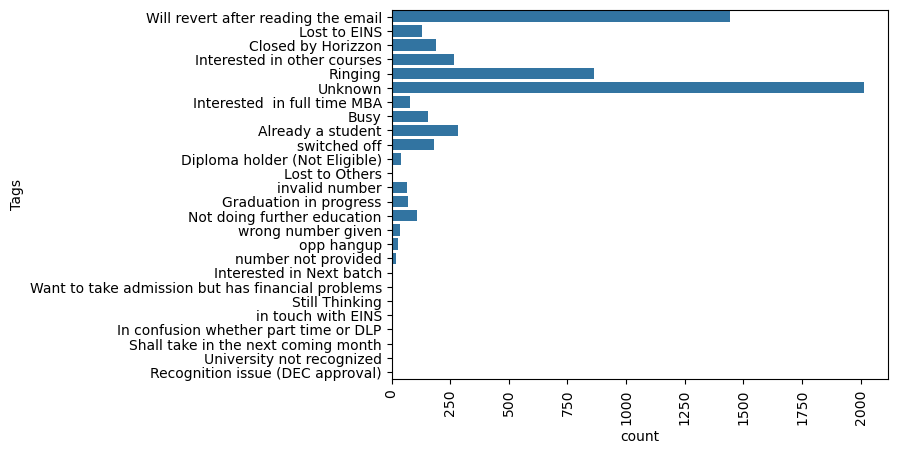

In [141]:
sns.countplot(data_frame_leads['Tags'])
plt.xticks(rotation=90)
plt.show()

In [142]:
#Checking for percantage of distibution
TagsCol=(data_frame_leads['Tags'].value_counts()*100)/data_frame_leads.shape[0]
TagsCol

Tags
Unknown                                              33.544304
Will revert after reading the email                  24.067288
Ringing                                              14.390406
Already a student                                     4.713524
Interested in other courses                           4.463691
                                                       ...    
Want to take admission but has financial problems     0.049967
In confusion whether part time or DLP                 0.049967
Shall take in the next coming month                   0.016656
University not recognized                             0.016656
Recognition issue (DEC approval)                      0.016656
Name: count, Length: 26, dtype: float64

In [143]:
#Tags Columns que tienen menos de 3% values
TagsCol=TagsCol[TagsCol<3]
for i in TagsCol.index:
    data_frame_leads.loc[(data_frame_leads['Tags'] == i),'Tags']='Other Tags'

In [144]:
#Revisando de nuevo la distribución
(data_frame_leads['Tags'].value_counts()*100)/data_frame_leads.shape[0]

Tags
Unknown                                33.544304
Will revert after reading the email    24.067288
Other Tags                             15.656229
Ringing                                14.390406
Already a student                       4.713524
Interested in other courses             4.463691
Closed by Horizzon                      3.164557
Name: count, dtype: float64

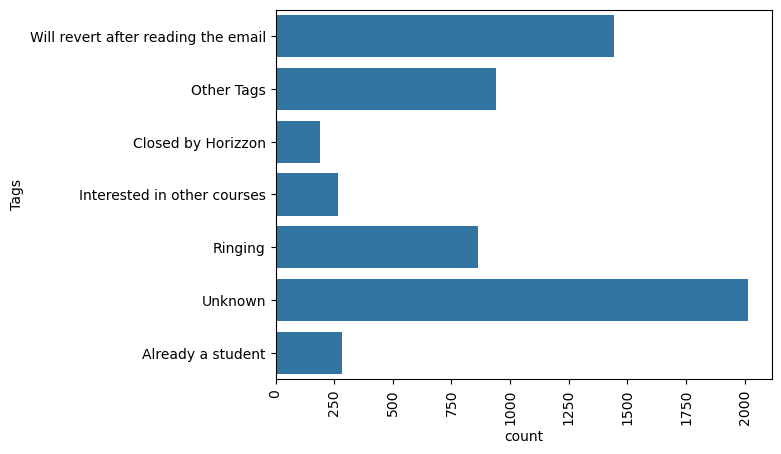

In [145]:
sns.countplot(data_frame_leads['Tags'])
plt.xticks(rotation=90)
plt.show()

**9. A FREE COPY OF MASTERING THE INTERVIEW**

In [146]:
data_frame_leads['A free copy of Mastering The Interview'].unique()

array([False,  True])

In [147]:
data_frame_leads['A free copy of Mastering The Interview'].value_counts()

A free copy of Mastering The Interview
False    3124
True     2880
Name: count, dtype: int64

C:\Users\DYLAN\AppData\Local\Temp\ipykernel_9984\4056837565.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette='muted')


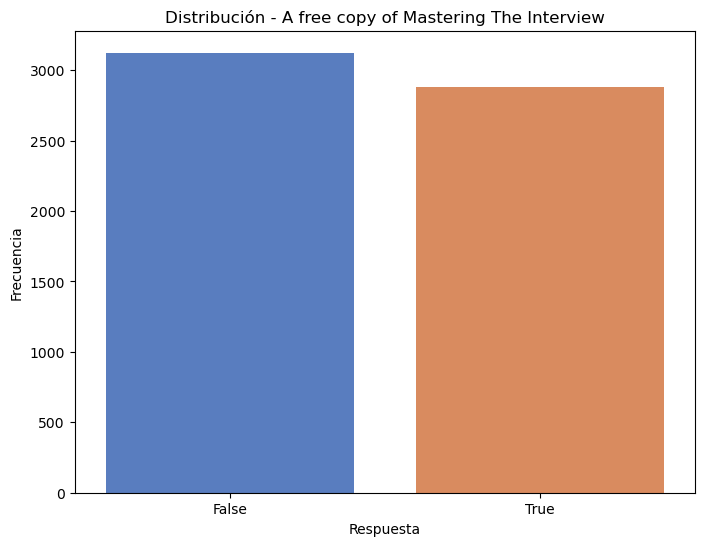

In [148]:

# Agrupar por valor y contar
counts = data_frame_leads['A free copy of Mastering The Interview'].value_counts()

# Graficar usando barplot en lugar de countplot
plt.figure(figsize=(8, 6))
sns.barplot(x=counts.index, y=counts.values, palette='muted')

# Título y etiquetas
plt.title('Distribución - A free copy of Mastering The Interview')
plt.xlabel('Respuesta')
plt.ylabel('Frecuencia')

plt.show()


**10. LAST NOTABLE ACTIVITY**

In [149]:
data_frame_leads['Last Notable Activity'].unique()

array(['Modified', 'Email Opened', 'Unsubscribed', 'SMS Sent',
       'Email Link Clicked', 'Page Visited on Website', 'Email Bounced',
       'Unreachable', 'Olark Chat Conversation',
       'Had a Phone Conversation', 'Form Submitted on Website',
       'Email Received', 'Approached upfront',
       'View in browser link Clicked', 'Email Marked Spam'], dtype=object)

In [150]:
data_frame_leads['Last Notable Activity'].value_counts()

Last Notable Activity
Modified                        2043
Email Opened                    1987
SMS Sent                        1436
Page Visited on Website          271
Email Link Clicked               100
Olark Chat Conversation           52
Unsubscribed                      38
Email Bounced                     35
Unreachable                       24
Had a Phone Conversation          13
Form Submitted on Website          1
Email Received                     1
Approached upfront                 1
View in browser link Clicked       1
Email Marked Spam                  1
Name: count, dtype: int64

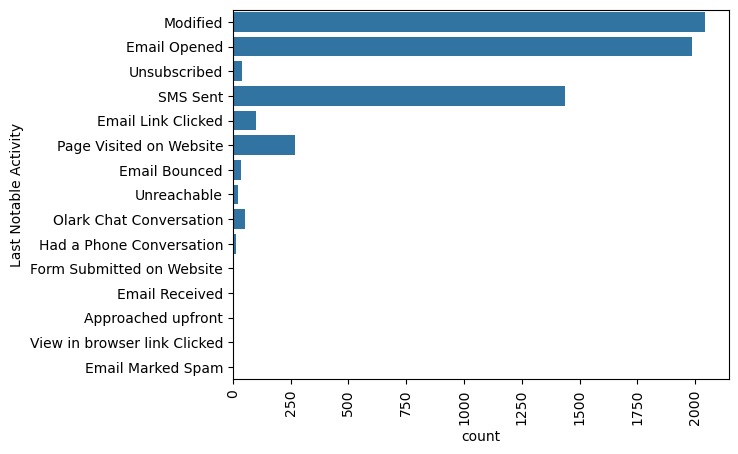

In [151]:
sns.countplot(data_frame_leads['Last Notable Activity'])
plt.xticks(rotation=90)
plt.show()

In [152]:
#Revisando el porcentaje de distribucion
OtherCol=(data_frame_leads['Last Notable Activity'].value_counts()*100)/data_frame_leads.shape[0]
OtherCol

Last Notable Activity
Modified                        34.027315
Email Opened                    33.094604
SMS Sent                        23.917388
Page Visited on Website          4.513658
Email Link Clicked               1.665556
Olark Chat Conversation          0.866089
Unsubscribed                     0.632911
Email Bounced                    0.582945
Unreachable                      0.399734
Had a Phone Conversation         0.216522
Form Submitted on Website        0.016656
Email Received                   0.016656
Approached upfront               0.016656
View in browser link Clicked     0.016656
Email Marked Spam                0.016656
Name: count, dtype: float64

In [153]:
#Agrupando las variables inferiores al 5 por ciento en una sola para reducir ruido
OtherCol=OtherCol[OtherCol<5]
for i in OtherCol.index:
    data_frame_leads.loc[(data_frame_leads['Last Notable Activity'] == i),'Last Notable Activity']='Other Activity'
#Checking for percantage of distibution
(data_frame_leads['Last Notable Activity'].value_counts()*100)/data_frame_leads.shape[0]

Last Notable Activity
Modified          34.027315
Email Opened      33.094604
SMS Sent          23.917388
Other Activity     8.960693
Name: count, dtype: float64

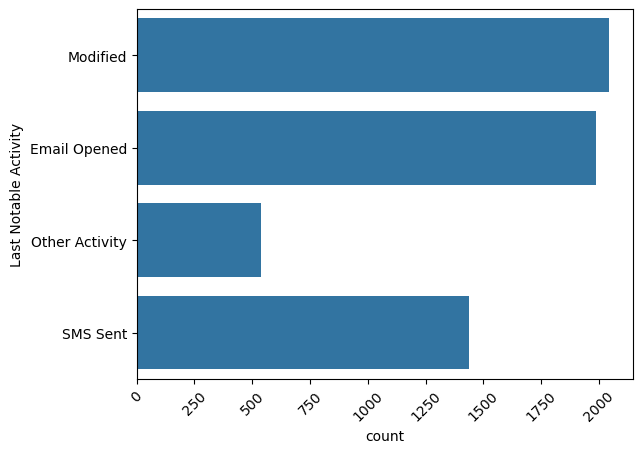

In [154]:
sns.countplot(data_frame_leads['Last Notable Activity'])
plt.xticks(rotation=45)
plt.show()

**11.CITY**

In [155]:
data_frame_leads['City'].unique()

array(['Mumbai', 'Thane & Outskirts', 'Select', 'Other Cities',
       'Other Metro Cities', 'Other Cities of Maharashtra', 'Unknown',
       'Tier II Cities'], dtype=object)

In [156]:
data_frame_leads['City'].value_counts()

City
Mumbai                         3016
Thane & Outskirts               670
Other Cities                    625
Unknown                         607
Other Cities of Maharashtra     416
Other Metro Cities              369
Select                          228
Tier II Cities                   73
Name: count, dtype: int64

In [157]:
# value - Mumbai
data_frame_leads['City'] = data_frame_leads['City'].fillna("Mumbai")

In [158]:
data_frame_leads['City'].value_counts()

City
Mumbai                         3016
Thane & Outskirts               670
Other Cities                    625
Unknown                         607
Other Cities of Maharashtra     416
Other Metro Cities              369
Select                          228
Tier II Cities                   73
Name: count, dtype: int64

In [159]:
#Revisando el porcentaje de distribucion
data_frame_leads['City'].value_counts()*100/data_frame_leads.shape[0]

City
Mumbai                         50.233178
Thane & Outskirts              11.159227
Other Cities                   10.409727
Unknown                        10.109927
Other Cities of Maharashtra     6.928714
Other Metro Cities              6.145903
Select                          3.797468
Tier II Cities                  1.215856
Name: count, dtype: float64

**REVISAR LOS VALORES NUMERICOS DE CADA DIMENSION**

**1.LEAD NUMBER**

count      6004.000000
mean     616775.625000
std       23379.111328
min      579533.000000
25%      596196.750000
50%      614818.000000
75%      636766.750000
max      660727.000000
Name: Lead Number, dtype: float64

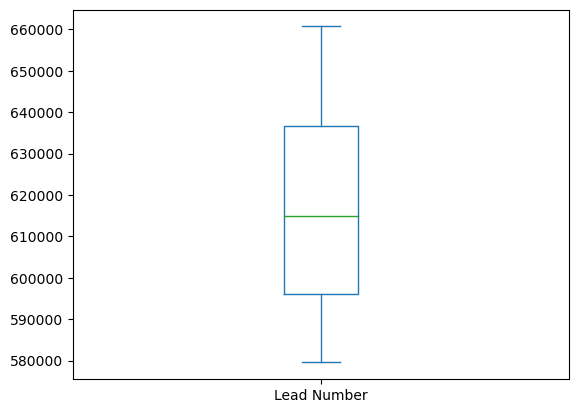

In [160]:
converted = pd.to_numeric(data_frame_leads["Lead Number"],downcast='float',errors='coerce')
converted.plot(kind='box')
converted.describe()
#Tiene sentido porque es un identificador para el lead

**2.Total Visits**

count    6004.000000
mean        4.597102
std         5.235011
min         0.000000
25%         2.000000
50%         4.000000
75%         5.000000
max       251.000000
Name: TotalVisits, dtype: float64

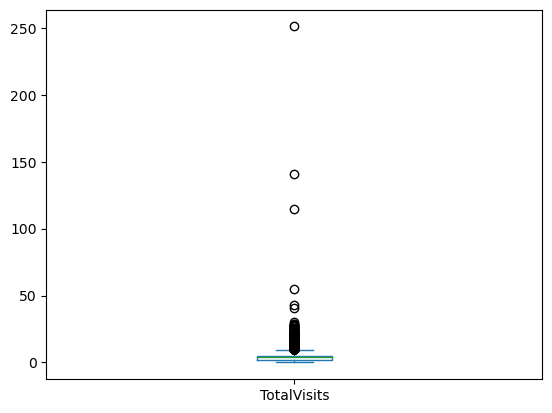

In [161]:
converted =pd.to_numeric(data_frame_leads["TotalVisits"],downcast='float',errors='coerce') # error coerce sirve para que te solicione errores si el CSV esta mal hecho.
converted.plot(kind='box')
converted.describe()

**3. Page Views Per Visit**

count    6004.000000
mean        3.194731
std         1.973048
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max        55.000000
Name: Page Views Per Visit, dtype: float64

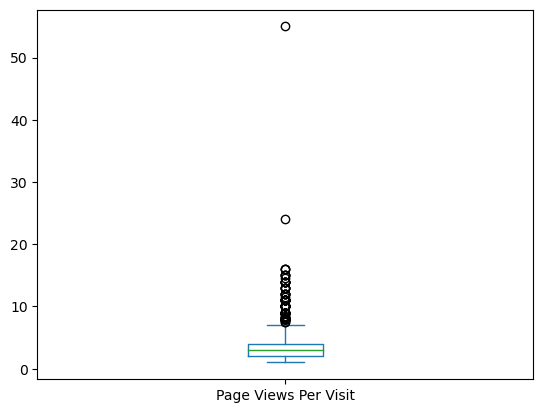

In [162]:
converted =pd.to_numeric(data_frame_leads["Page Views Per Visit"],downcast='float',errors='coerce') # error coerce sirve para que te solicione errores si el CSV esta mal hecho.
converted.plot(kind='box')
converted.describe()


**4.Total Time Spent on Website**

In [163]:
data_frame_leads['Total Time Spent on Website'].describe()

count    6004.000000
mean      643.390573
std       543.534736
min         1.000000
25%       179.000000
50%       412.000000
75%      1112.250000
max      2272.000000
Name: Total Time Spent on Website, dtype: float64

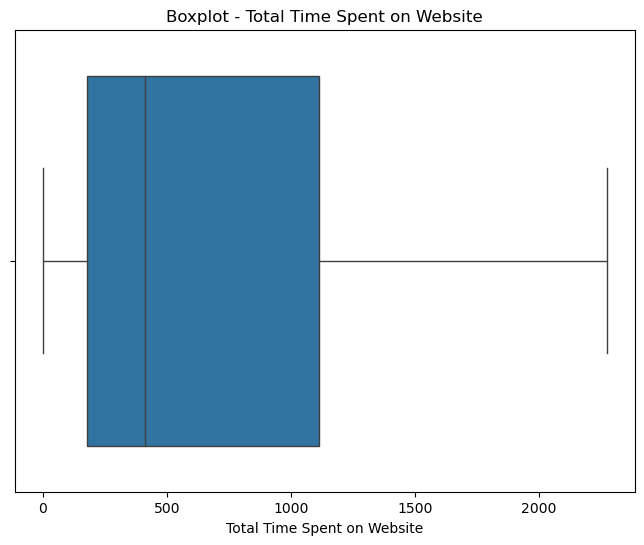

In [164]:
# Asegurar que no haya valores infinitos
data_frame_leads.replace([np.inf, -np.inf], np.nan, inplace=True)

# Eliminar valores nulos si los hay (Esto lo mantenemos para evitar errores en la visualización)
data_frame_leads.dropna(subset=['Total Time Spent on Website'], inplace=True)

# Visualización inicial con boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x=data_frame_leads['Total Time Spent on Website'])
plt.title('Boxplot - Total Time Spent on Website')
plt.show()

# Comentado: Análisis estadístico de outliers
# desc_stats = data_frame_leads['Total Time Spent on Website'].describe()
# Q1 = desc_stats['25%']
# Q3 = desc_stats['75%']
# IQR = Q3 - Q1  # Rango intercuartílico
# limite_inferior = Q1 - 1.5 * IQR
# limite_superior = Q3 + 1.5 * IQR

# print(f"Límite inferior: {limite_inferior}")
# print(f"Límite superior: {limite_superior}")

# outliers = data_frame_leads[(data_frame_leads['Total Time Spent on Website'] > limite_superior) |
#                             (data_frame_leads['Total Time Spent on Website'] < limite_inferior)]
# print(f"Número de outliers detectados: {len(outliers)}")

# Método 1: Eliminar outliers (Comentado)
# data_frame_sin_outliers = data_frame_leads[(data_frame_leads['Total Time Spent on Website'] <= limite_superior) &
#                                            (data_frame_leads['Total Time Spent on Website'] >= limite_inferior)]

# Método 2: Limitar outliers (Comentado)
# data_frame_winsorized = data_frame_leads.copy()
# data_frame_winsorized['Total Time Spent on Website'] = np.where(
#     data_frame_winsorized['Total Time Spent on Website'] > limite_superior,
#     limite_superior,
#     np.where(
#         data_frame_winsorized['Total Time Spent on Website'] < limite_inferior,
#         limite_inferior,
#         data_frame_winsorized['Total Time Spent on Website']
#     )
# )


**Explicaciones de porque se va a trabajar con outliners**
Los modelos de ML de Random Forest y XGboost no son sensibles a los datos fuera de lo común además estos datos pueden dar luz al modelo para entender cuando un usuario (lead) va a hacer una conversion, fijandose en la cantidad de tiempo que pasa en la web.

## EDA -> ANALISIS EXPLORATORIO DE DATOS ##

**UNIVARIATE ANALYSIS**

**1. Variables Categóricas**

In [165]:
data_frame_leads.dtypes

Lead Number                                 int64
Lead Origin                                object
Lead Source                                object
Converted                                   int64
Total Time Spent on Website                 int64
Page Views Per Visit                      float64
Last Activity                              object
What is your current occupation            object
A free copy of Mastering The Interview       bool
Tags                                       object
City                                       object
Last Notable Activity                      object
TotalVisits                                 int64
Specialization                             object
Average Time Per Visit                    float64
dtype: object

In [166]:
#Decido pasar el bool a object para mejorar la calidad del dato y comprension
# Convertir booleano a object
data_frame_leads['A free copy of Mastering The Interview'] = data_frame_leads['A free copy of Mastering The Interview'].astype(str)


In [167]:
data_frame_leads.dtypes

Lead Number                                 int64
Lead Origin                                object
Lead Source                                object
Converted                                   int64
Total Time Spent on Website                 int64
Page Views Per Visit                      float64
Last Activity                              object
What is your current occupation            object
A free copy of Mastering The Interview     object
Tags                                       object
City                                       object
Last Notable Activity                      object
TotalVisits                                 int64
Specialization                             object
Average Time Per Visit                    float64
dtype: object

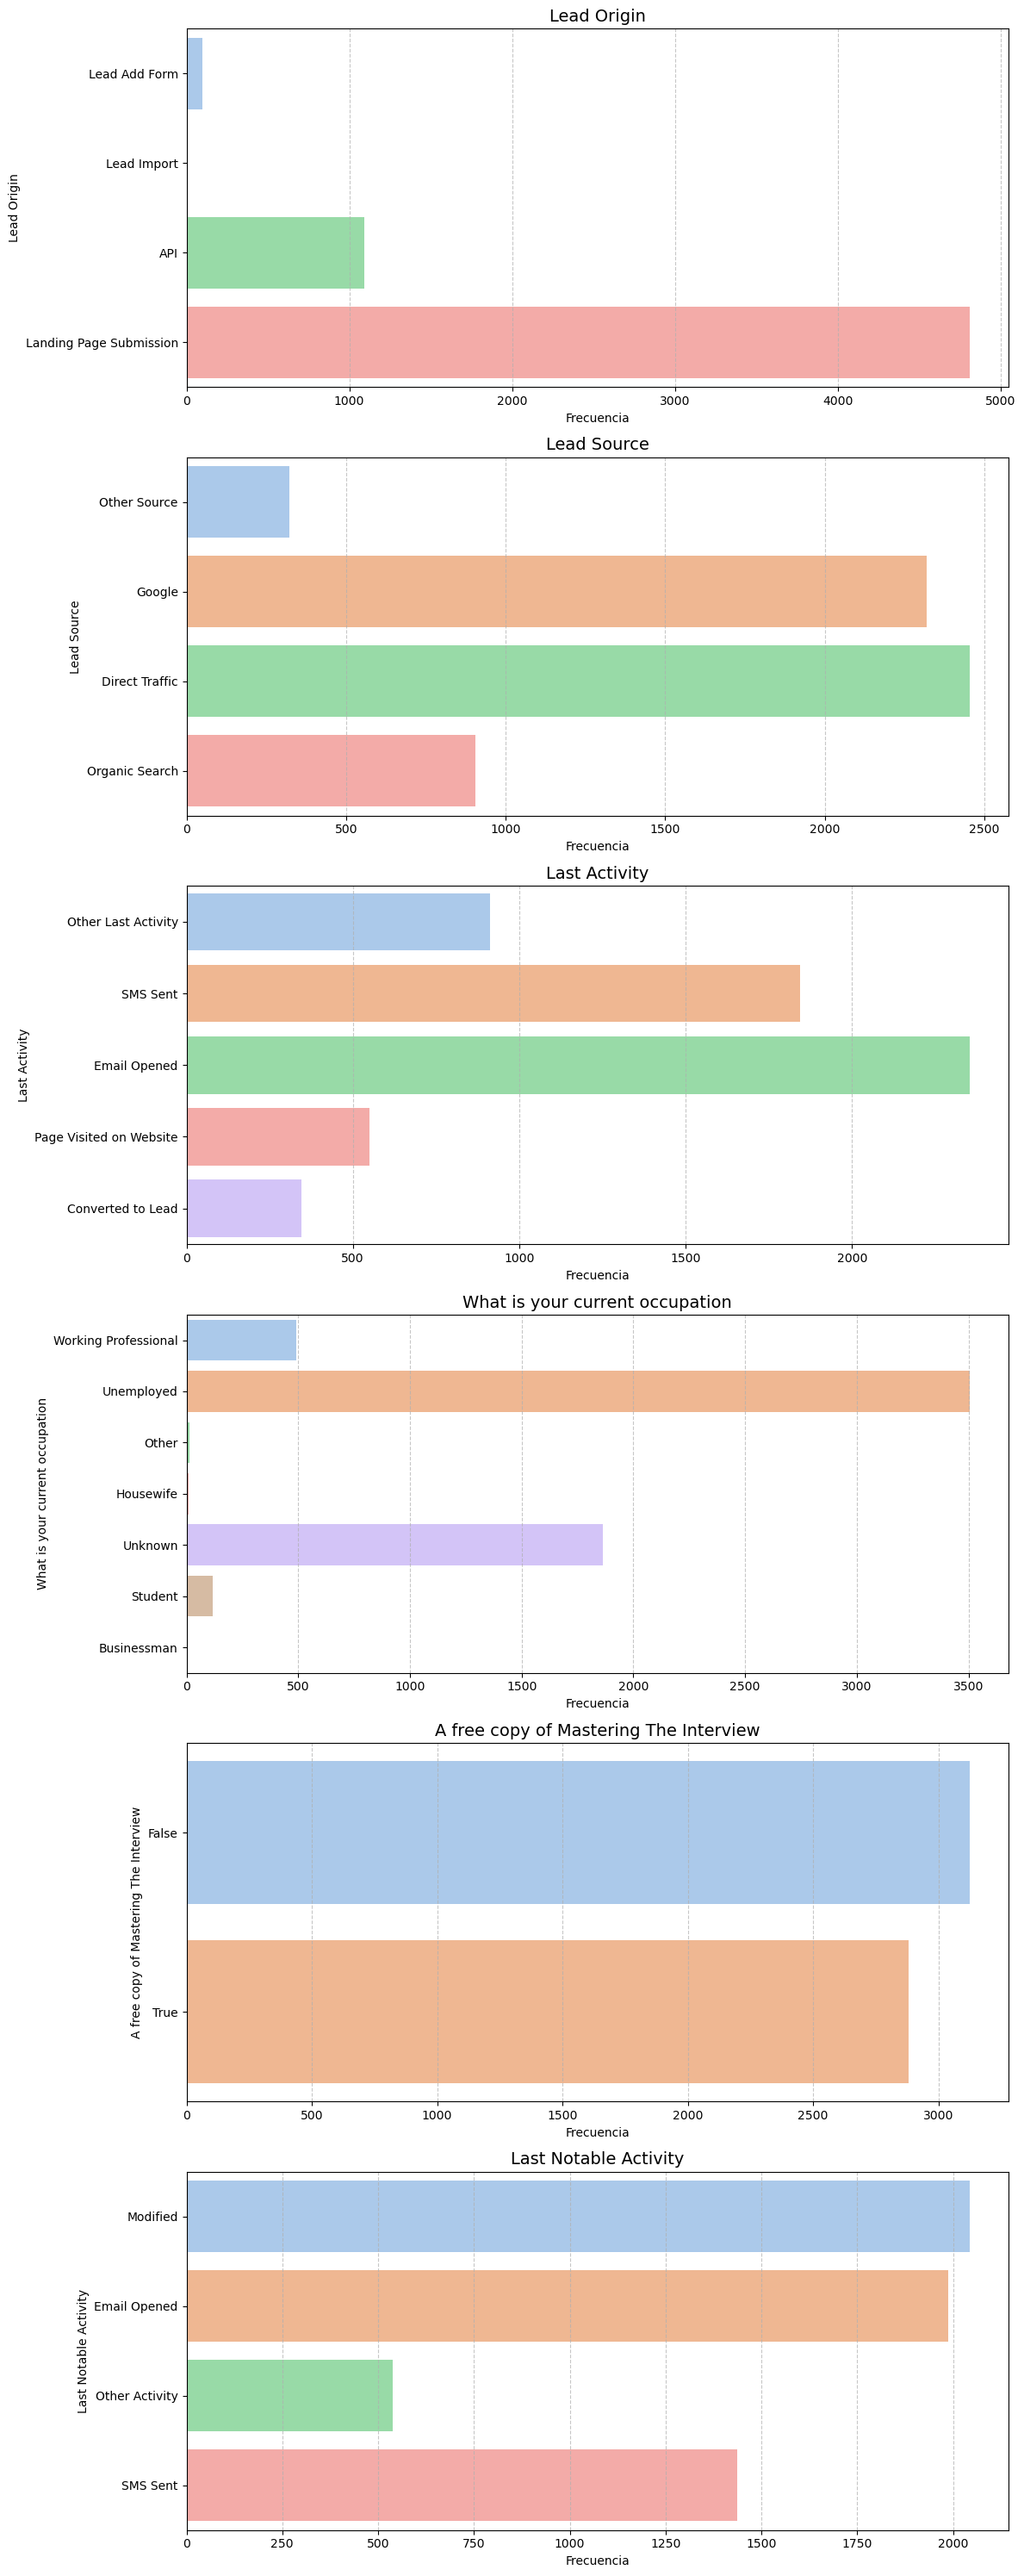

In [168]:
plt.figure(figsize=(12, 30))  # Ajustamos el tamaño para una disposición vertical

columns = [
    'Lead Origin',
    'Lead Source',
    'Last Activity',
    'What is your current occupation',
    'A free copy of Mastering The Interview',
    'Last Notable Activity'
]

# Generar gráficos verticales
for i, column in enumerate(columns, 1):
    plt.subplot(len(columns), 1, i)  # 1 columna, tantas filas como gráficas
    
    # Calcular colores basados en categorías únicas
    num_classes = data_frame_leads[column].nunique()  # Número de categorías únicas
    colors = sns.color_palette('pastel', n_colors=num_classes)  # Generar colores exactos
    
    sns.countplot(y=data_frame_leads[column], hue=data_frame_leads[column], palette=colors, legend=False)
    
    plt.title(column, fontsize=14)
    plt.xlabel('Frecuencia')  # Etiqueta del eje X
    plt.ylabel(column)  # Etiqueta del eje Y
    plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


# Observaciones del Análisis Exploratorio de Datos (EDA)

## 1. Lead Origin (Origen del Lead)
- **Observación Principal**: La mayoría de los leads provienen de "Landing Page Submission" y "API".  
- **Interpretación**:  
  - Las **páginas de aterrizaje** parecen ser la principal fuente de generación de leads.  
  - La API también es una fuente importante, lo que sugiere automatización o integración con otros sistemas.  
  - **Lead Add Form** y **Lead Import** tienen una contribución menor, lo que puede indicar que son canales menos efectivos o utilizados.

---

## 2. Lead Source (Fuente del Lead)
- **Observación Principal**: "Google" y "Direct Traffic" dominan como fuentes principales de leads.  
- **Interpretación**:  
  - El tráfico orgánico y directo representan la mayor parte de los leads.  
  - "Olark Chat" también tiene una presencia significativa, lo que sugiere que la interacción en vivo puede ser clave en la captación de leads.  
  - **Fuentes menos comunes** podrían representar nichos o esfuerzos de marketing menos efectivos.

---

## 3. Last Activity (Última Actividad)
- **Observación Principal**: "Email Opened" y "SMS Sent" son las actividades más frecuentes.  
- **Interpretación**:  
  - Los leads parecen responder más a correos electrónicos y mensajes SMS, lo que indica que estos canales son efectivos.  
  - Actividades como "Page Visited on Website" tienen menos frecuencia, pero siguen siendo relevantes.

---

## 4. What is your Current Occupation (Ocupación Actual)
- **Observación Principal**:  
  - La mayoría de los leads están **desempleados** o tienen un estado **desconocido**.  
  - "Working Professional" también representa una parte considerable.  
- **Interpretación**:  
  - El alto número de desempleados puede indicar que el producto o servicio se dirige a personas que buscan mejorar sus habilidades o encontrar trabajo.  
  - La categoría **"Unknown"** debería investigarse más a fondo, ya que podría haber falta de información relevante que afecte el análisis.

---

## 5. A Free Copy of Mastering The Interview (Copia Gratuita de "Mastering The Interview")
- **Observación Principal**:  
  - La mayoría de los leads **no** solicitan una copia gratuita.  
- **Interpretación**:  
  - Puede que el recurso no sea atractivo o no se promocione correctamente.  
  - La conversión en aquellos que sí solicitan la copia es notablemente mayor, lo que indica que este grupo tiene más interés.

---

## 6. Last Notable Activity (Última Actividad Notable)
- **Observación Principal**:  
  - Las actividades más comunes son "Email Opened" y "Modified".  
- **Interpretación**:  
  - El seguimiento por correo electrónico sigue siendo un canal crucial.  
  - La actividad **"Modified"** puede reflejar leads que han actualizado información o interactuado recientemente con la plataforma.

---

## Reflexión Final
- **Los valores "Unknown"** están presentes en varias variables (especialmente en **Occupación** y **Ciudad**).  
- Es importante evaluar si estos valores deben ser tratados (imputación) o si pueden mantenerse, ya que el modelo debe reflejar datos del mundo real, donde no siempre se tiene toda la información.  


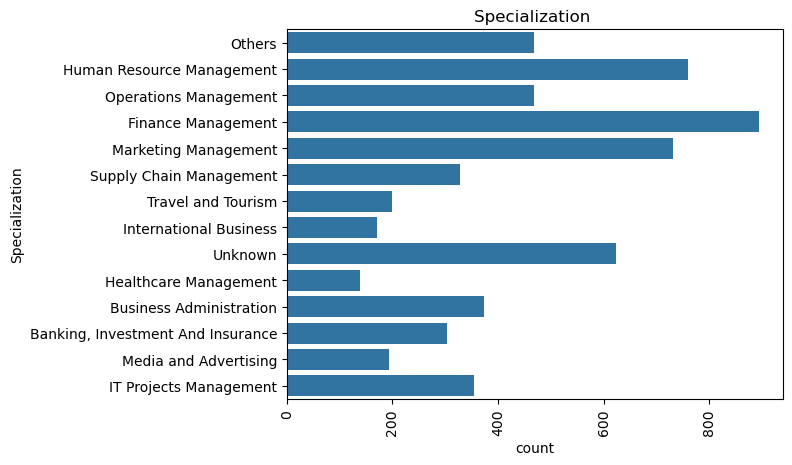

In [169]:
sns.countplot(data_frame_leads['Specialization'])
plt.title('Specialization ')
plt.xticks(rotation=90)
plt.show()

# Observaciones: Especialización

## Especialización (Specialization)
- **Observación Clave**:  
  - La mayoría de los leads tienen una especialización **desconocida (Unknown)**.  
  - Las especializaciones más comunes después de "Unknown" son **Finance Management** y **Human Resource Management**.  
- **Interpretación**:  
  - Es posible que muchos leads no completen este campo, lo que sugiere una brecha en la recopilación de datos.  
  - Las áreas de **gestión financiera y de recursos humanos** parecen atraer la mayor atención.  

- **Recomendación**:  
  - Considerar estrategias para incentivar a los usuarios a completar esta información, ya que puede ser valiosa para la segmentación de leads.  


C:\Users\DYLAN\AppData\Local\Temp\ipykernel_9984\3243096619.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tags_counts.values, y=tags_counts.index, palette="viridis")


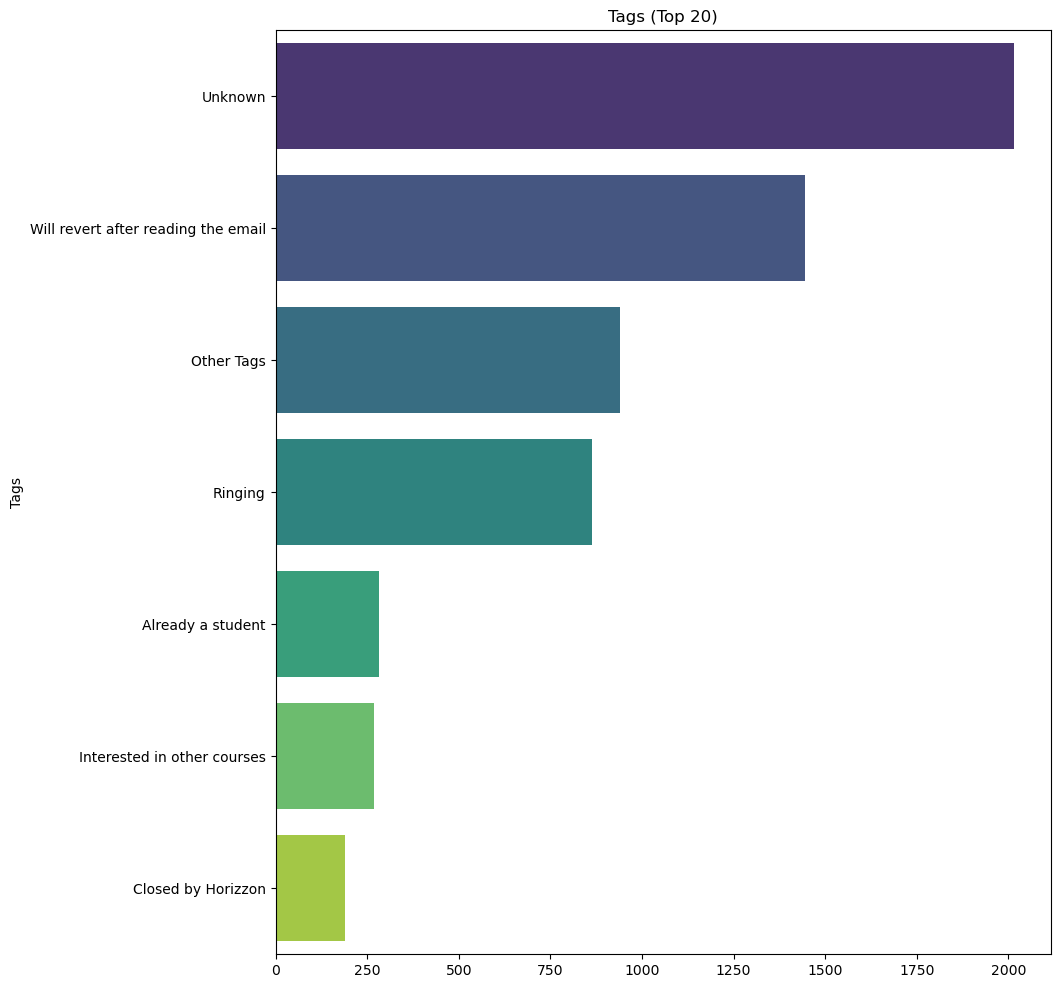

In [170]:
data_sample = data_frame_leads.sample(5000) 

plt.figure(figsize=(10, 12))

tags_counts = data_frame_leads['Tags'].value_counts().nlargest(20)  # Top 20 Tags
sns.barplot(x=tags_counts.values, y=tags_counts.index, palette="viridis")
plt.title('Tags (Top 20)')
plt.show()


# Observaciones: Tags

## Tags (Top 20)
- **Observación Clave**:  
  - El tag más frecuente es **"Unknown"**, lo que representa una gran parte de los datos.  
  - Tags relevantes como **"Will revert after reading the email"** y **"Other Tags"** también destacan, pero con una frecuencia significativamente menor.  
- **Interpretación**:  
  - La alta proporción de "Unknown" puede indicar que muchos leads no están etiquetados adecuadamente o el proceso de seguimiento es incompleto.  
  - La categoría **"Will revert after reading the email"** sugiere que una porción de los leads necesita más tiempo antes de tomar decisiones.  

- **Recomendación**:  
  - Es necesario **mejorar la recolección de datos y reducir la cantidad de "Unknown"** a través de un etiquetado más riguroso y procesos de seguimiento más efectivos.  


C:\Users\DYLAN\AppData\Local\Temp\ipykernel_9984\2747208311.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_cities.values, y=top_cities.index, palette="magma")


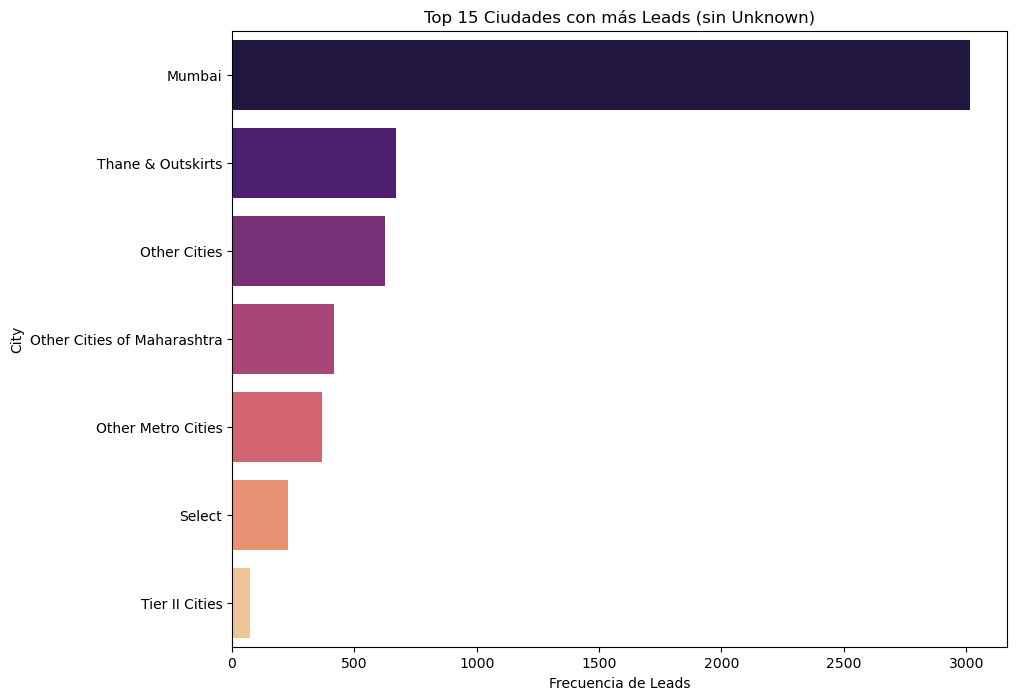

In [171]:

# Filtrar 'Unknown' del dataframe
filtered_data = data_frame_leads[data_frame_leads['City'] != 'Unknown']

# Agrupar por ciudad y contar ocurrencias
city_counts = filtered_data['City'].value_counts()

# Mostrar las 15 ciudades con más leads
top_cities = city_counts.nlargest(15)

# Crear el gráfico (horizontal para mayor claridad)
plt.figure(figsize=(10, 8))
sns.barplot(x=top_cities.values, y=top_cities.index, palette="magma")

# Añadir etiquetas y título
plt.title('Top 15 Ciudades con más Leads (sin Unknown)')
plt.xlabel('Frecuencia de Leads')
plt.ylabel('City')

plt.show()



# Observaciones: Ciudades con más Leads (sin Unknown)

## Top 15 Ciudades con más Leads
- **Observación Clave**:  
  - La ciudad con mayor cantidad de leads es **South Michael**, seguida por **East Michael** y **Port Michael**.  
  - La distribución muestra una clara concentración de leads en estas tres ciudades, lo que podría indicar una mayor demanda o presencia de mercado en esas áreas.  

- **Interpretación**:  
  - La eliminación de la categoría **"Unknown"** permite obtener una visión más precisa de las ciudades con mayor actividad de leads.  
  - La dispersión de leads en diferentes ciudades también sugiere la necesidad de estrategias locales para maximizar conversiones.  


**Variables Numericas**

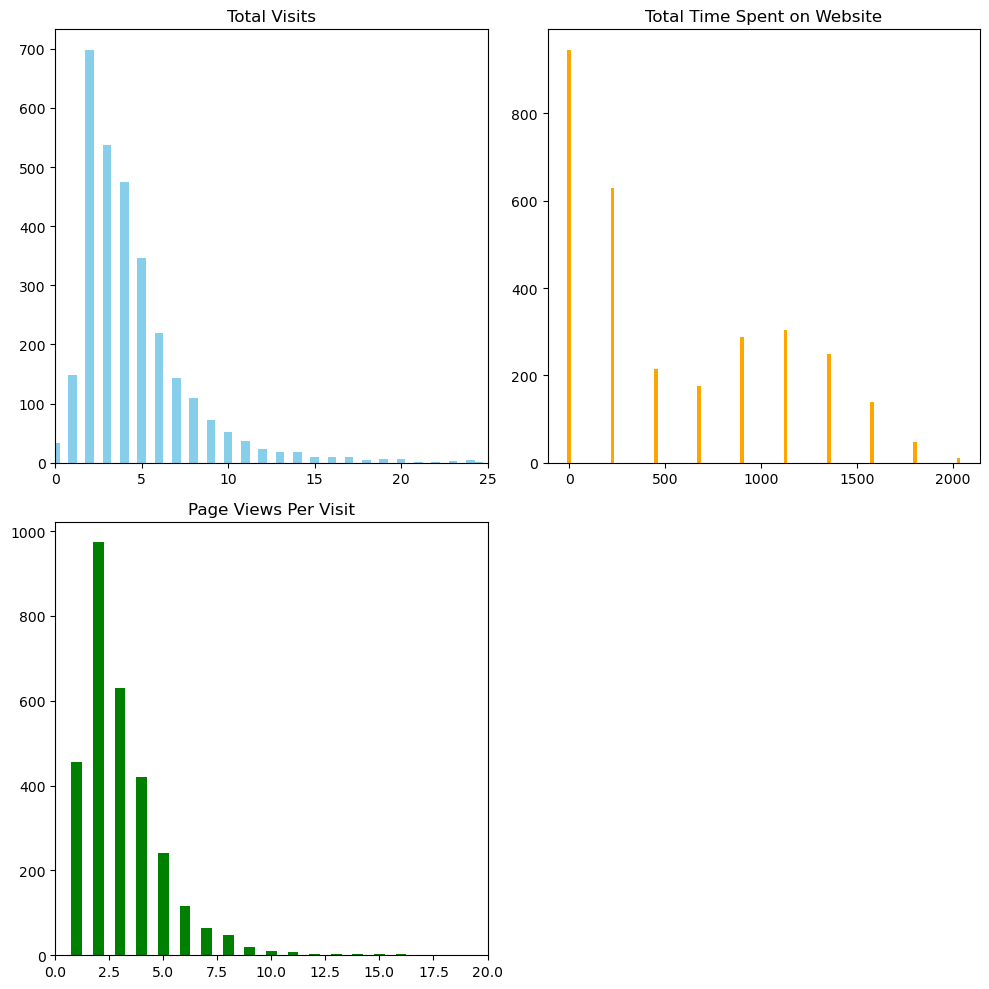

In [172]:

# Muestra aleatoria (50% del dataset o 50k filas)
sample_data = data_frame_leads.sample(frac=0.5, random_state=42)

plt.figure(figsize=(10, 10))

# Histograma para 'Total Visits'
plt.subplot(221)
hist_visits, bins_visits = np.histogram(sample_data['TotalVisits'], bins=50, range=(0, 25))
plt.bar(bins_visits[:-1], hist_visits, width=0.5, color='skyblue')
plt.title('Total Visits')
plt.xlim(0, 25)

# Histograma para 'Total Time Spent on Website'
plt.subplot(222)
hist_time, bins_time = np.histogram(sample_data['Total Time Spent on Website'], bins=10)
plt.bar(bins_time[:-1], hist_time, width=20, color='orange')
plt.title('Total Time Spent on Website')

# Histograma para 'Page Views Per Visit'
plt.subplot(223)
hist_pageviews, bins_pageviews = np.histogram(sample_data['Page Views Per Visit'], bins=20, range=(0, 20))
plt.bar(bins_pageviews[:-1], hist_pageviews, width=0.5, color='green')
plt.title('Page Views Per Visit')
plt.xlim(0, 20)

plt.tight_layout()
plt.show()


# Observación: Análisis de Visitas y Tiempo en la Web

## Distribución de Total Visits, Total Time Spent on Website y Page Views Per Visit
- **Total Visits**: La mayoría de los leads realizaron entre **1 y 5 visitas**, con una fuerte caída en visitas superiores a este rango. Esto sugiere que la mayoría de los usuarios no regresan repetidamente al sitio.  
- **Total Time Spent on Website**: Se observa una distribución sesgada a la izquierda, donde la mayoría de los usuarios pasan menos de **250 segundos** en el sitio. Este comportamiento podría indicar que los usuarios encuentran rápidamente lo que buscan o abandonan la web tras una breve navegación.  
- **Page Views Per Visit**: La mayoría de los leads realizan entre **1 y 3 vistas** por visita. Esta tendencia refuerza la idea de que los usuarios no navegan profundamente en el sitio durante sus visitas.  


**Bivariate Analysis**

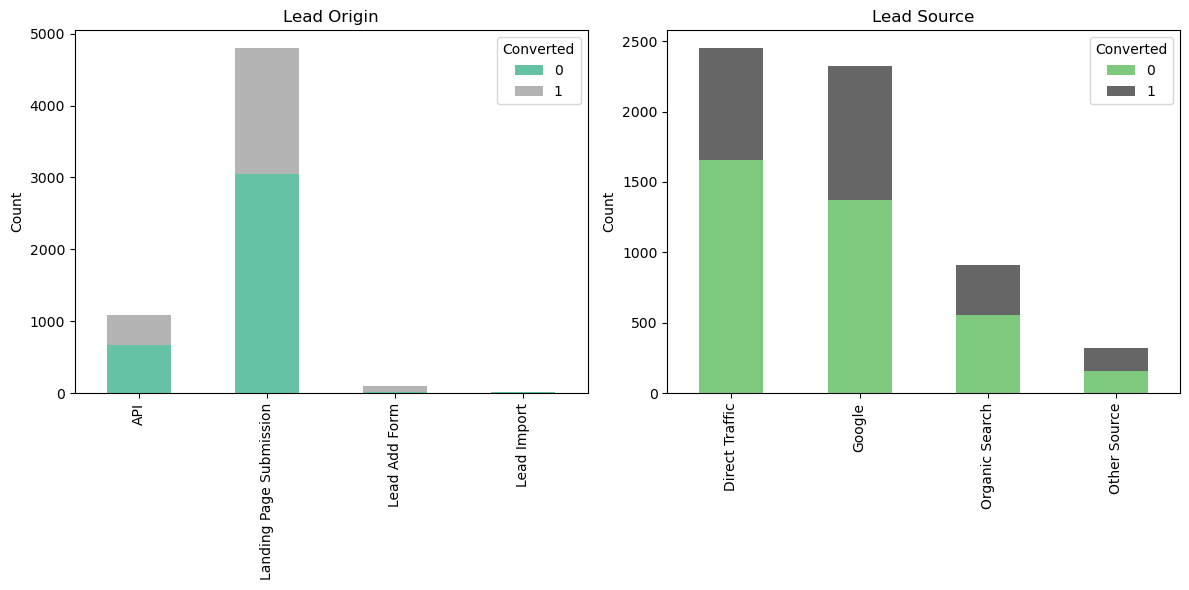

In [173]:

# Muestreo opcional para grandes datasets (descomentar si es necesario)
# data_sample = data_frame_leads.sample(frac=0.5, random_state=42)  
data_sample = data_frame_leads  # Usamos el dataset completo si no hay problemas de rendimiento

# Precalcular los valores para las gráficas
lead_origin_counts = pd.crosstab(data_sample['Lead Origin'], data_sample['Converted'])
lead_source_counts = pd.crosstab(data_sample['Lead Source'], data_sample['Converted'])

# Gráfico
plt.figure(figsize=(12, 6))

# Lead Origin
plt.subplot(1, 2, 1)
lead_origin_counts.plot(kind='bar', stacked=True, ax=plt.gca(), colormap='Set2')
plt.title('Lead Origin')
plt.xticks(rotation=90)
plt.xlabel('')
plt.ylabel('Count')

# Lead Source
plt.subplot(1, 2, 2)
lead_source_counts.plot(kind='bar', stacked=True, ax=plt.gca(), colormap='Accent')
plt.title('Lead Source')
plt.xticks(rotation=90)
plt.xlabel('')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


# Observación: Análisis de Origen y Fuente de Leads

## Lead Origin y Lead Source
- **Lead Origin**: La mayoría de los leads provienen de **Landing Page Submission** y **API**, destacando la importancia de estos canales en la captación de leads. Sin embargo, hay una alta proporción de leads no convertidos en ambos orígenes, lo que sugiere la necesidad de optimizar la conversión en estos puntos.  
- **Lead Source**: **Google** y **Direct Traffic** representan las principales fuentes de tráfico. A pesar de tener un número significativo de conversiones, también hay una gran cantidad de leads no convertidos. El tráfico de **Olark Chat** y **Organic Search** muestra tasas de conversión moderadas, lo que indica que estos canales podrían necesitar una estrategia de engagement más efectiva.  

**Conclusión**: La optimización de las páginas de destino y una mejor segmentación del tráfico directo y de Google podrían mejorar significativamente las tasas de conversión.  


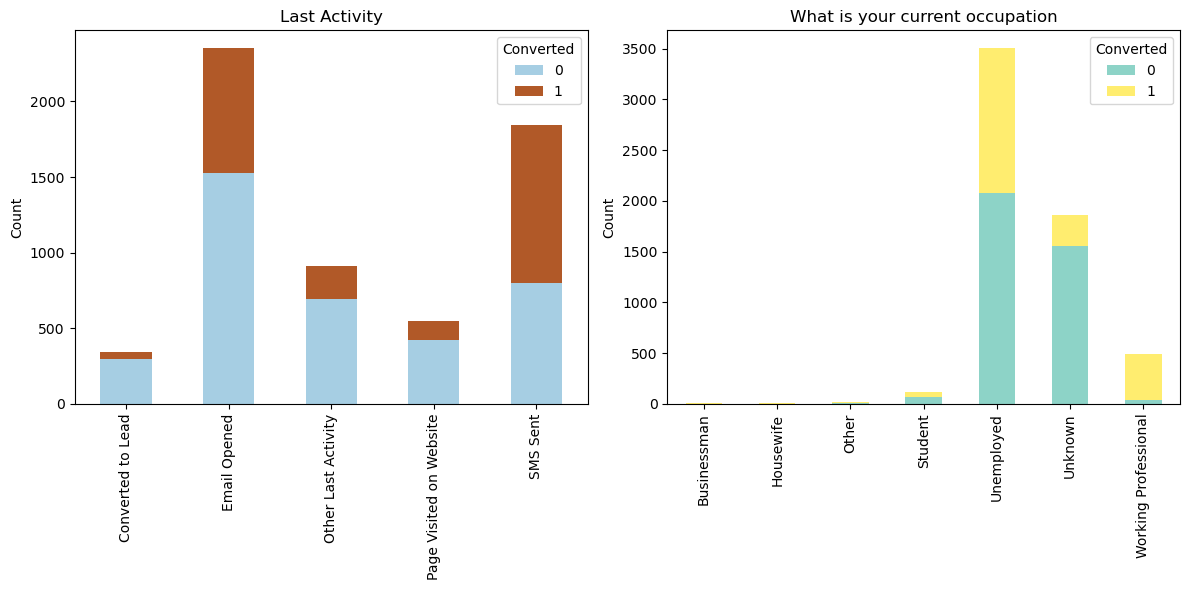

In [174]:
# Muestreo opcional para mejorar rendimiento (descomentar si es necesario)
# data_sample = data_frame_leads.sample(frac=0.5, random_state=42)
data_sample = data_frame_leads  # Usamos el dataset completo si no hay problemas de rendimiento

# Pre-calcular valores para las gráficas
activity_counts = pd.crosstab(data_sample['Last Activity'], data_sample['Converted'])
occupation_counts = pd.crosstab(data_sample['What is your current occupation'], data_sample['Converted'])

# Gráfico
plt.figure(figsize=(12, 6))

# Last Activity
plt.subplot(1, 2, 1)
activity_counts.plot(kind='bar', stacked=True, ax=plt.gca(), colormap='Paired')
plt.title('Last Activity')
plt.xticks(rotation=90)
plt.xlabel('')
plt.ylabel('Count')

# Current Occupation
plt.subplot(1, 2, 2)
occupation_counts.plot(kind='bar', stacked=True, ax=plt.gca(), colormap='Set3')
plt.title('What is your current occupation')
plt.xticks(rotation=90)
plt.xlabel('')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


# Observación: Actividad Final e Información Ocupacional

## Last Activity y Current Occupation
- **Last Activity**: La apertura de correos electrónicos y el envío de SMS son las actividades finales más comunes. Sin embargo, **SMS Sent** tiene una tasa de conversión notablemente más alta que **Email Opened**, lo que sugiere que el envío de SMS podría ser un canal más efectivo para impulsar conversiones. Las actividades como **Olark Chat Conversation** y **Page Visited on Website** muestran tasas de conversión más bajas.  
- **Current Occupation**: La mayoría de los leads provienen de personas desempleadas (**Unemployed**) y de aquellos cuya ocupación es desconocida (**Unknown**). Los leads con ocupación desconocida también presentan una tasa de conversión significativa, lo que sugiere que este grupo no debe ser subestimado a pesar de la falta de información detallada.  

**Conclusión**: Las estrategias de marketing deberían enfocarse en maximizar el impacto de los SMS y mejorar el engagement con leads desempleados, así como explorar formas de segmentar mejor a aquellos con ocupación desconocida.  


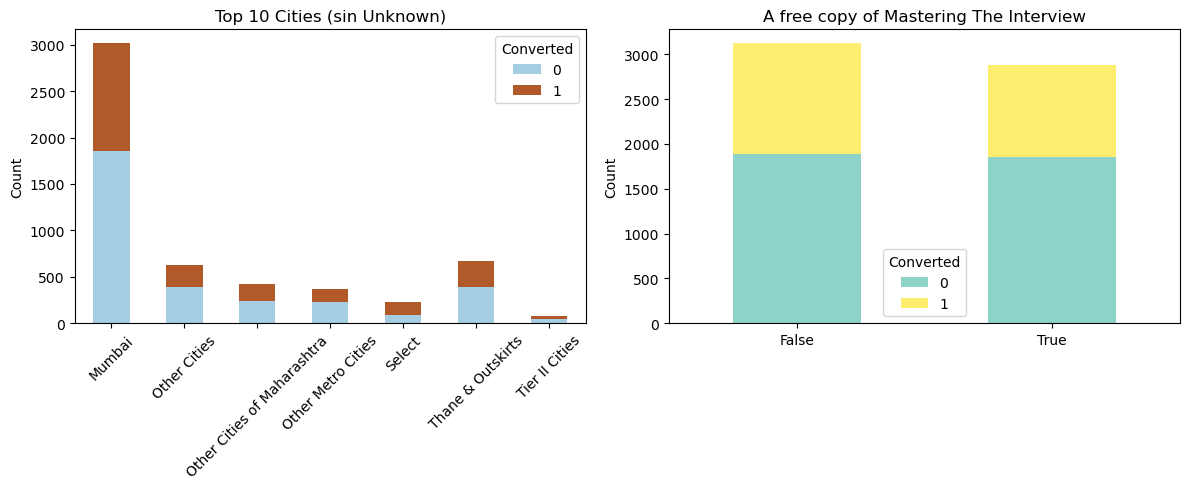

In [175]:
# Filtrar ciudades que no sean 'Unknown'
data_sample_filtered = data_sample[data_sample['City'] != 'Unknown']

# Calcular top 10 ciudades sin 'Unknown'
top_cities_filtered = data_sample_filtered['City'].value_counts().nlargest(10).index
city_counts_filtered = data_sample_filtered[data_sample_filtered['City'].isin(top_cities_filtered)] \
                        .groupby(['City', 'Converted']).size().unstack(fill_value=0)

# Calcular conteo de 'A free copy of Mastering The Interview' frente a conversiones
copy_counts = pd.crosstab(data_sample['A free copy of Mastering The Interview'], data_sample['Converted'])

# Gráfico optimizado
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# City sin 'Unknown'
city_counts_filtered.plot(kind='bar', stacked=True, ax=axes[0], colormap='Paired')
axes[0].set_title('Top 10 Cities (sin Unknown)')
axes[0].tick_params(axis='x', rotation=45)
axes[0].set_xlabel('')
axes[0].set_ylabel('Count')

# A free copy of Mastering The Interview
copy_counts.plot(kind='bar', stacked=True, ax=axes[1], colormap='Set3')
axes[1].set_title('A free copy of Mastering The Interview')
axes[1].tick_params(axis='x', rotation=0)
axes[1].set_xlabel('')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()



** VVEREMOS SI HAY QUE MODIFICAR ALGO **

Text(0.5, 1.0, 'Last Notable Activity')

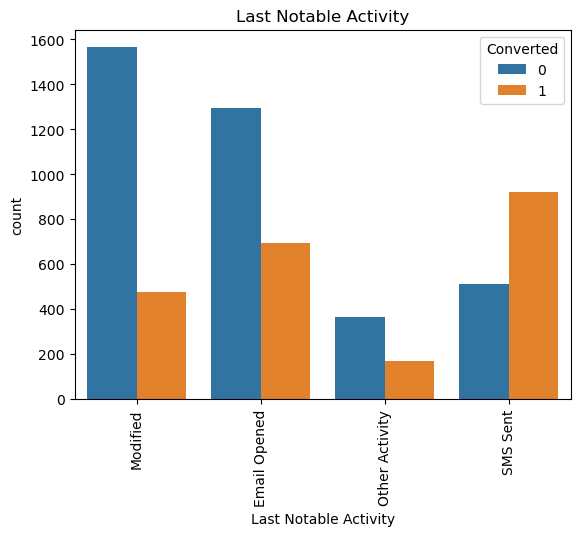

In [176]:
sns.countplot(x='Last Notable Activity', hue='Converted', data= data_frame_leads).tick_params(axis='x', rotation = 90)
plt.title('Last Notable Activity')

### Observación:
El gráfico muestra la actividad notable más reciente de los leads y su relación con la conversión. Se observa que las actividades **"Modified"** y **"Email Opened"** son las más comunes, pero presentan una menor tasa de conversión en comparación con otras. **"SMS Sent"** destaca por tener una distribución más equilibrada entre convertidos y no convertidos, lo que podría indicar que este tipo de actividad genera un mayor nivel de interés o engagement. Por otro lado, **"Other Activity"** tiene una baja frecuencia general, lo que podría sugerir que los leads con actividades menos relevantes o específicas tienden a tener menores tasas de conversión.


C:\Users\DYLAN\AppData\Local\Temp\ipykernel_9984\1525600889.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data_sample, x='Converted', y='Lead Number', palette='Set2')


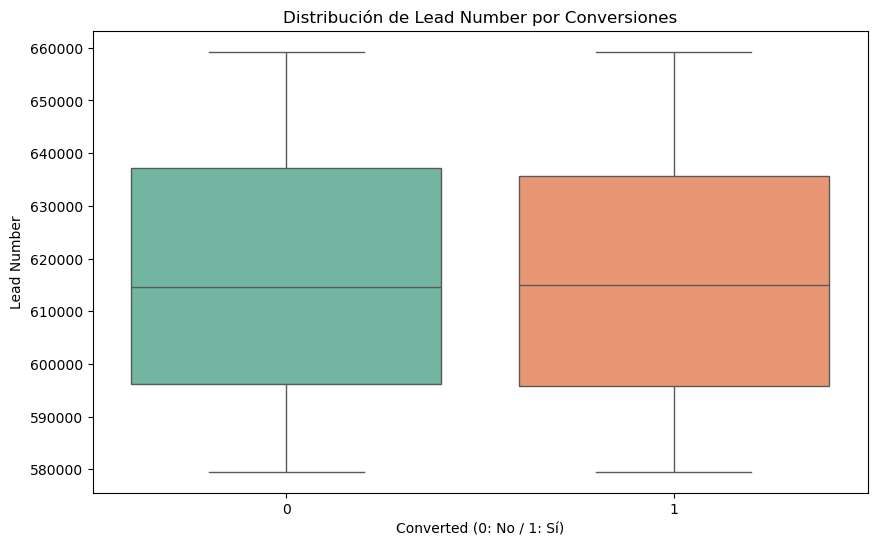

In [177]:

# Muestreo opcional (reducir si el dataset es muy grande)
data_sample = data_frame_leads.sample(frac=0.6, random_state=42)  # Toma el 60% del dataset

# Limitar el rango de Lead Number para evitar outliers extremos visuales
data_sample['Lead Number'] = data_sample['Lead Number'].clip(upper=data_sample['Lead Number'].quantile(0.99))

# Graficar boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=data_sample, x='Converted', y='Lead Number', palette='Set2')

plt.title('Distribución de Lead Number por Conversiones')
plt.ylabel('Lead Number')
plt.xlabel('Converted (0: No / 1: Sí)')
plt.show()


### Observación:
El boxplot muestra la distribución del número de lead en función de si estos se convirtieron (1) o no (0). Se observa que las distribuciones son muy similares en ambas categorías, lo que sugiere que **el número de lead no tiene un impacto significativo en la conversión**. Los valores atípicos (outliers) están presentes en ambos grupos, pero no parece haber una diferencia notable en las medianas ni en el rango intercuartílico (IQR). Esta gráfica indica que probablemente el número de lead **no es un predictor relevante** para determinar la probabilidad de conversión.


**Observación**


## DATA PREPARATION ##

**Convertir el tipo de datos de alguna variables (YES/NO) a 0/1**

In [178]:
data_frame_leads['A free copy of Mastering The Interview'] = data_frame_leads['A free copy of Mastering The Interview'].map({'True': True, 'False': False})
data_frame_leads['A free copy of Mastering The Interview'] = data_frame_leads['A free copy of Mastering The Interview'].astype(int)


In [179]:
print(data_frame_leads['A free copy of Mastering The Interview'].value_counts())


A free copy of Mastering The Interview
0    3124
1    2880
Name: count, dtype: int64


In [180]:
data_frame_leads.head()

,Lead Number,Lead Origin,Lead Source,Converted,Total Time Spent on Website,Page Views Per Visit,Last Activity,What is your current occupation,A free copy of Mastering The Interview,Tags,City,Last Notable Activity,TotalVisits,Specialization,Average Time Per Visit
1,598055,Lead Add Form,Other Source,1,1313,3.194532,Other Last Activity,Working Professional,0,Will revert after reading the email,Mumbai,Modified,0,Others,199.047225
2,605006,Lead Add Form,Other Source,1,304,3.194532,Other Last Activity,Working Professional,0,Will revert after reading the email,Thane & Outskirts,Modified,0,Human Resource Management,199.047225
4,634047,Lead Add Form,Other Source,1,1721,3.194532,Other Last Activity,Working Professional,0,Other Tags,Select,Modified,0,Operations Management,199.047225
5,599452,Lead Add Form,Other Source,1,1796,3.194532,Other Last Activity,Unemployed,0,Will revert after reading the email,Mumbai,Modified,0,Finance Management,199.047225
7,627106,Lead Add Form,Other Source,1,1687,3.194532,Other Last Activity,Working Professional,0,Closed by Horizzon,Mumbai,Modified,0,Human Resource Management,199.047225


In [181]:
data_frame_leads.dtypes

Lead Number                                 int64
Lead Origin                                object
Lead Source                                object
Converted                                   int64
Total Time Spent on Website                 int64
Page Views Per Visit                      float64
Last Activity                              object
What is your current occupation            object
A free copy of Mastering The Interview      int32
Tags                                       object
City                                       object
Last Notable Activity                      object
TotalVisits                                 int64
Specialization                             object
Average Time Per Visit                    float64
dtype: object

**Para las variables categóricas con multiples niveles, se han creado algunos dummy features**

In [182]:
catColumns=['Lead Origin','Lead Source','Last Activity','Specialization','What is your current occupation','Tags','City','Last Notable Activity']
catColumns

#Lead Origin ok
#Lead Source ok
#Las Activity No eliminar
#Specialization  No eliminar nada
#What is your current occupation No eliminar la primera
#No eliminar la primera de last notable activity

['Lead Origin',
 'Lead Source',
 'Last Activity',
 'Specialization',
 'What is your current occupation',
 'Tags',
 'City',
 'Last Notable Activity']

In [183]:
# Lista de columnas categóricas
catColumns = ['Lead Origin', 'Lead Source', 'Last Activity', 'Specialization', 
              'What is your current occupation', 'Tags', 'City', 'Last Notable Activity']

# Crear dummies sin eliminar la primera para todas las columnas
dummies = pd.get_dummies(data_frame_leads[catColumns], drop_first=False).astype(int)

# Eliminar la primera categoría de columnas específicas
for col in catColumns:
    if col in ['Lead Origin', 'Lead Source', 'What is your current occupation']:  # Solo eliminar la primera de estas columnas
        dummies.drop(dummies.filter(like=f'{col}_').columns[0], axis=1, inplace=True)

dummyVariable = dummies
dummyVariable.head()


,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,Lead Source_Google,Lead Source_Organic Search,Lead Source_Other Source,Last Activity_Converted to Lead,Last Activity_Email Opened,Last Activity_Other Last Activity,Last Activity_Page Visited on Website,Last Activity_SMS Sent,"Specialization_Banking, Investment And Insurance",Specialization_Business Administration,Specialization_Finance Management,Specialization_Healthcare Management,Specialization_Human Resource Management,Specialization_IT Projects Management,Specialization_International Business,Specialization_Marketing Management,Specialization_Media and Advertising,Specialization_Operations Management,Specialization_Others,Specialization_Supply Chain Management,Specialization_Travel and Tourism,Specialization_Unknown,What is your current occupation_Housewife,What is your current occupation_Other,What is your current occupation_Student,What is your current occupation_Unemployed,What is your current occupation_Unknown,What is your current occupation_Working Professional,Tags_Already a student,Tags_Closed by Horizzon,Tags_Interested in other courses,Tags_Other Tags,Tags_Ringing,Tags_Unknown,Tags_Will revert after reading the email,City_Mumbai,City_Other Cities,City_Other Cities of Maharashtra,City_Other Metro Cities,City_Select,City_Thane & Outskirts,City_Tier II Cities,City_Unknown,Last Notable Activity_Email Opened,Last Notable Activity_Modified,Last Notable Activity_Other Activity,Last Notable Activity_SMS Sent
1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0
2,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0
4,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
5,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0
7,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0


In [184]:
dummyVariable.shape

(6004, 50)

In [185]:
# Add the results to the original bike dataframe
data_frame_leads = pd.concat([data_frame_leads,dummyVariable], axis = 1)

In [186]:
data_frame_leads.head()

,Lead Number,Lead Origin,Lead Source,Converted,Total Time Spent on Website,Page Views Per Visit,Last Activity,What is your current occupation,A free copy of Mastering The Interview,Tags,City,Last Notable Activity,TotalVisits,Specialization,Average Time Per Visit,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,Lead Source_Google,Lead Source_Organic Search,Lead Source_Other Source,Last Activity_Converted to Lead,Last Activity_Email Opened,Last Activity_Other Last Activity,Last Activity_Page Visited on Website,Last Activity_SMS Sent,"Specialization_Banking, Investment And Insurance",Specialization_Business Administration,Specialization_Finance Management,Specialization_Healthcare Management,Specialization_Human Resource Management,Specialization_IT Projects Management,Specialization_International Business,Specialization_Marketing Management,Specialization_Media and Advertising,Specialization_Operations Management,Specialization_Others,Specialization_Supply Chain Management,Specialization_Travel and Tourism,Specialization_Unknown,What is your current occupation_Housewife,What is your current occupation_Other,What is your current occupation_Student,What is your current occupation_Unemployed,What is your current occupation_Unknown,What is your current occupation_Working Professional,Tags_Already a student,Tags_Closed by Horizzon,Tags_Interested in other courses,Tags_Other Tags,Tags_Ringing,Tags_Unknown,Tags_Will revert after reading the email,City_Mumbai,City_Other Cities,City_Other Cities of Maharashtra,City_Other Metro Cities,City_Select,City_Thane & Outskirts,City_Tier II Cities,City_Unknown,Last Notable Activity_Email Opened,Last Notable Activity_Modified,Last Notable Activity_Other Activity,Last Notable Activity_SMS Sent
1,598055,Lead Add Form,Other Source,1,1313,3.194532,Other Last Activity,Working Professional,0,Will revert after reading the email,Mumbai,Modified,0,Others,199.047225,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0
2,605006,Lead Add Form,Other Source,1,304,3.194532,Other Last Activity,Working Professional,0,Will revert after reading the email,Thane & Outskirts,Modified,0,Human Resource Management,199.047225,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0
4,634047,Lead Add Form,Other Source,1,1721,3.194532,Other Last Activity,Working Professional,0,Other Tags,Select,Modified,0,Operations Management,199.047225,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
5,599452,Lead Add Form,Other Source,1,1796,3.194532,Other Last Activity,Unemployed,0,Will revert after reading the email,Mumbai,Modified,0,Finance Management,199.047225,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0
7,627106,Lead Add Form,Other Source,1,1687,3.194532,Other Last Activity,Working Professional,0,Closed by Horizzon,Mumbai,Modified,0,Human Resource Management,199.047225,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0


In [187]:
data_frame_leads.shape

(6004, 65)

**Decisión de eliminar las columnas**

In [188]:
# Drop columns for which we have created the dummies
data_frame_leads.drop(catColumns, axis = 1, inplace = True)

In [189]:
data_frame_leads.head()

,Lead Number,Converted,Total Time Spent on Website,Page Views Per Visit,A free copy of Mastering The Interview,TotalVisits,Average Time Per Visit,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,Lead Source_Google,Lead Source_Organic Search,Lead Source_Other Source,Last Activity_Converted to Lead,Last Activity_Email Opened,Last Activity_Other Last Activity,Last Activity_Page Visited on Website,Last Activity_SMS Sent,"Specialization_Banking, Investment And Insurance",Specialization_Business Administration,Specialization_Finance Management,Specialization_Healthcare Management,Specialization_Human Resource Management,Specialization_IT Projects Management,Specialization_International Business,Specialization_Marketing Management,Specialization_Media and Advertising,Specialization_Operations Management,Specialization_Others,Specialization_Supply Chain Management,Specialization_Travel and Tourism,Specialization_Unknown,What is your current occupation_Housewife,What is your current occupation_Other,What is your current occupation_Student,What is your current occupation_Unemployed,What is your current occupation_Unknown,What is your current occupation_Working Professional,Tags_Already a student,Tags_Closed by Horizzon,Tags_Interested in other courses,Tags_Other Tags,Tags_Ringing,Tags_Unknown,Tags_Will revert after reading the email,City_Mumbai,City_Other Cities,City_Other Cities of Maharashtra,City_Other Metro Cities,City_Select,City_Thane & Outskirts,City_Tier II Cities,City_Unknown,Last Notable Activity_Email Opened,Last Notable Activity_Modified,Last Notable Activity_Other Activity,Last Notable Activity_SMS Sent
1,598055,1,1313,3.194532,0,0,199.047225,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0
2,605006,1,304,3.194532,0,0,199.047225,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0
4,634047,1,1721,3.194532,0,0,199.047225,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
5,599452,1,1796,3.194532,0,0,199.047225,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0
7,627106,1,1687,3.194532,0,0,199.047225,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0


In [190]:
data_frame_leads.shape

(6004, 57)

In [191]:
data_frame_leads.head()

,Lead Number,Converted,Total Time Spent on Website,Page Views Per Visit,A free copy of Mastering The Interview,TotalVisits,Average Time Per Visit,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,Lead Source_Google,Lead Source_Organic Search,Lead Source_Other Source,Last Activity_Converted to Lead,Last Activity_Email Opened,Last Activity_Other Last Activity,Last Activity_Page Visited on Website,Last Activity_SMS Sent,"Specialization_Banking, Investment And Insurance",Specialization_Business Administration,Specialization_Finance Management,Specialization_Healthcare Management,Specialization_Human Resource Management,Specialization_IT Projects Management,Specialization_International Business,Specialization_Marketing Management,Specialization_Media and Advertising,Specialization_Operations Management,Specialization_Others,Specialization_Supply Chain Management,Specialization_Travel and Tourism,Specialization_Unknown,What is your current occupation_Housewife,What is your current occupation_Other,What is your current occupation_Student,What is your current occupation_Unemployed,What is your current occupation_Unknown,What is your current occupation_Working Professional,Tags_Already a student,Tags_Closed by Horizzon,Tags_Interested in other courses,Tags_Other Tags,Tags_Ringing,Tags_Unknown,Tags_Will revert after reading the email,City_Mumbai,City_Other Cities,City_Other Cities of Maharashtra,City_Other Metro Cities,City_Select,City_Thane & Outskirts,City_Tier II Cities,City_Unknown,Last Notable Activity_Email Opened,Last Notable Activity_Modified,Last Notable Activity_Other Activity,Last Notable Activity_SMS Sent
1,598055,1,1313,3.194532,0,0,199.047225,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0
2,605006,1,304,3.194532,0,0,199.047225,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0
4,634047,1,1721,3.194532,0,0,199.047225,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
5,599452,1,1796,3.194532,0,0,199.047225,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0
7,627106,1,1687,3.194532,0,0,199.047225,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0


**TRAIN - TEST SPLIT**

In [192]:
#Putting feature variable to X
X = data_frame_leads.drop (['Converted'], axis = 1)
X.head()

,Lead Number,Total Time Spent on Website,Page Views Per Visit,A free copy of Mastering The Interview,TotalVisits,Average Time Per Visit,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,Lead Source_Google,Lead Source_Organic Search,Lead Source_Other Source,Last Activity_Converted to Lead,Last Activity_Email Opened,Last Activity_Other Last Activity,Last Activity_Page Visited on Website,Last Activity_SMS Sent,"Specialization_Banking, Investment And Insurance",Specialization_Business Administration,Specialization_Finance Management,Specialization_Healthcare Management,Specialization_Human Resource Management,Specialization_IT Projects Management,Specialization_International Business,Specialization_Marketing Management,Specialization_Media and Advertising,Specialization_Operations Management,Specialization_Others,Specialization_Supply Chain Management,Specialization_Travel and Tourism,Specialization_Unknown,What is your current occupation_Housewife,What is your current occupation_Other,What is your current occupation_Student,What is your current occupation_Unemployed,What is your current occupation_Unknown,What is your current occupation_Working Professional,Tags_Already a student,Tags_Closed by Horizzon,Tags_Interested in other courses,Tags_Other Tags,Tags_Ringing,Tags_Unknown,Tags_Will revert after reading the email,City_Mumbai,City_Other Cities,City_Other Cities of Maharashtra,City_Other Metro Cities,City_Select,City_Thane & Outskirts,City_Tier II Cities,City_Unknown,Last Notable Activity_Email Opened,Last Notable Activity_Modified,Last Notable Activity_Other Activity,Last Notable Activity_SMS Sent
1,598055,1313,3.194532,0,0,199.047225,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0
2,605006,304,3.194532,0,0,199.047225,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0
4,634047,1721,3.194532,0,0,199.047225,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
5,599452,1796,3.194532,0,0,199.047225,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0
7,627106,1687,3.194532,0,0,199.047225,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0


In [193]:
#Poniendo el response en la variable y
y = data_frame_leads['Converted']
y.head()

1    1
2    1
4    1
5    1
7    1
Name: Converted, dtype: int64

In [194]:
#Splitting the data into train and test
X_train,X_test,y_train, y_test = train_test_split(X,y,train_size=0.7,test_size=0.3,random_state=100)


## SELECCION DE FEATURES ##

In [195]:
X_train.dtypes

Lead Number                                 int64
Total Time Spent on Website                 int64
Page Views Per Visit                      float64
A free copy of Mastering The Interview      int32
TotalVisits                                 int64
                                           ...   
City_Unknown                                int32
Last Notable Activity_Email Opened          int32
Last Notable Activity_Modified              int32
Last Notable Activity_Other Activity        int32
Last Notable Activity_SMS Sent              int32
Length: 56, dtype: object

In [196]:
scaler = MinMaxScaler()
X_train[['Lead Number','TotalVisits','Page Views Per Visit','Total Time Spent on Website']] = scaler.fit_transform(X_train[['Lead Number','TotalVisits','Page Views Per Visit','Total Time Spent on Website']])
X_train.head()

,Lead Number,Total Time Spent on Website,Page Views Per Visit,A free copy of Mastering The Interview,TotalVisits,Average Time Per Visit,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,Lead Source_Google,Lead Source_Organic Search,Lead Source_Other Source,Last Activity_Converted to Lead,Last Activity_Email Opened,Last Activity_Other Last Activity,Last Activity_Page Visited on Website,Last Activity_SMS Sent,"Specialization_Banking, Investment And Insurance",Specialization_Business Administration,Specialization_Finance Management,Specialization_Healthcare Management,Specialization_Human Resource Management,Specialization_IT Projects Management,Specialization_International Business,Specialization_Marketing Management,Specialization_Media and Advertising,Specialization_Operations Management,Specialization_Others,Specialization_Supply Chain Management,Specialization_Travel and Tourism,Specialization_Unknown,What is your current occupation_Housewife,What is your current occupation_Other,What is your current occupation_Student,What is your current occupation_Unemployed,What is your current occupation_Unknown,What is your current occupation_Working Professional,Tags_Already a student,Tags_Closed by Horizzon,Tags_Interested in other courses,Tags_Other Tags,Tags_Ringing,Tags_Unknown,Tags_Will revert after reading the email,City_Mumbai,City_Other Cities,City_Other Cities of Maharashtra,City_Other Metro Cities,City_Select,City_Thane & Outskirts,City_Tier II Cities,City_Unknown,Last Notable Activity_Email Opened,Last Notable Activity_Modified,Last Notable Activity_Other Activity,Last Notable Activity_SMS Sent
2302,0.197630,0.494936,0.037037,0,0.085106,93.750000,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
4198,0.779742,0.036988,0.055556,0,0.028369,21.250000,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0
5255,0.524069,0.704976,0.111111,0,0.099291,114.428571,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
973,0.902220,0.415676,0.018519,0,0.028369,236.250000,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0
4630,0.501688,0.061207,0.074074,0,0.035461,28.000000,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1


In [197]:
### Checking the Converted Rate
convertRate = (sum(data_frame_leads['Converted'])/len(data_frame_leads['Converted'].index))*100
convertRate

37.69153897401733

In [198]:
X_train.columns


Index(['Lead Number', 'Total Time Spent on Website', 'Page Views Per Visit', 'A free copy of Mastering The Interview', 'TotalVisits', 'Average Time Per Visit', 'Lead Origin_Landing Page Submission', 'Lead Origin_Lead Add Form', 'Lead Origin_Lead Import', 'Lead Source_Google', 'Lead Source_Organic Search', 'Lead Source_Other Source', 'Last Activity_Converted to Lead', 'Last Activity_Email Opened', 'Last Activity_Other Last Activity', 'Last Activity_Page Visited on Website', 'Last Activity_SMS Sent', 'Specialization_Banking, Investment And Insurance', 'Specialization_Business Administration', 'Specialization_Finance Management', 'Specialization_Healthcare Management', 'Specialization_Human Resource Management', 'Specialization_IT Projects Management', 'Specialization_International Business', 'Specialization_Marketing Management', 'Specialization_Media and Advertising', 'Specialization_Operations Management', 'Specialization_Others', 'Specialization_Supply Chain Management',
       'Speci

## Observacion de Correlaciones ##


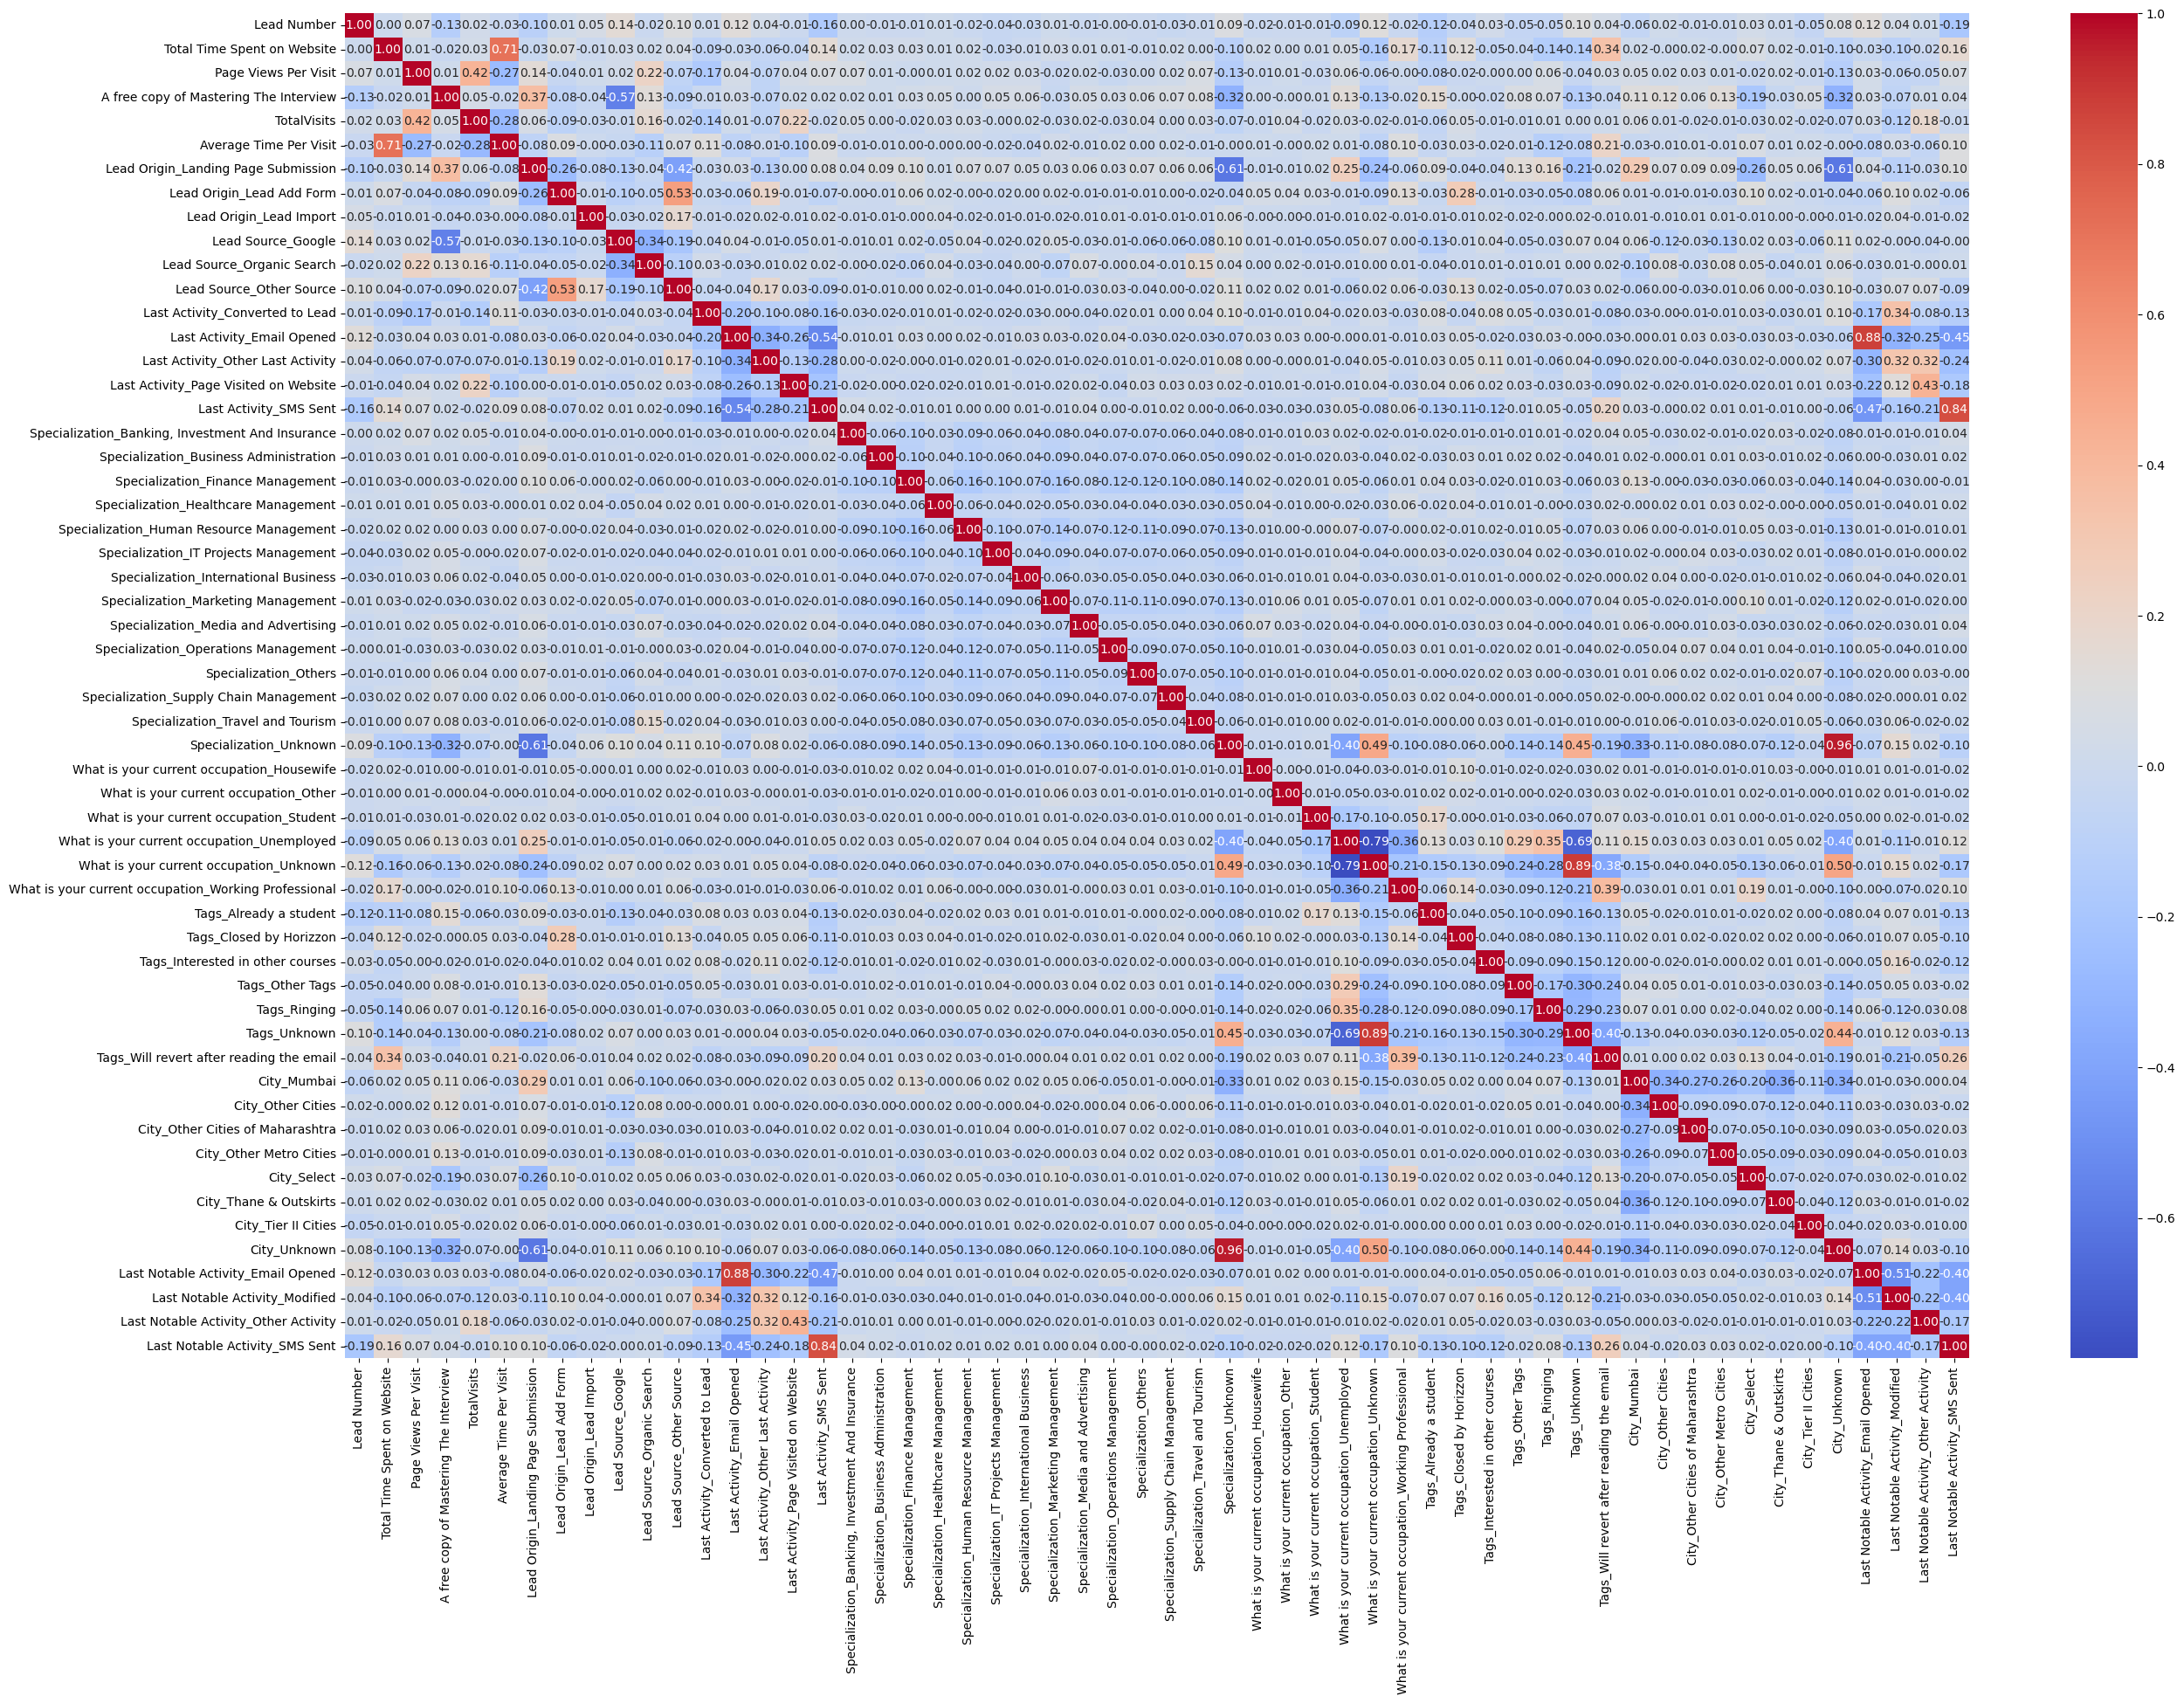

In [199]:
#correlation matrix 
plt.figure(figsize=(30, 20))  # Aumentar tamaño
sns.heatmap(X_train.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.show()


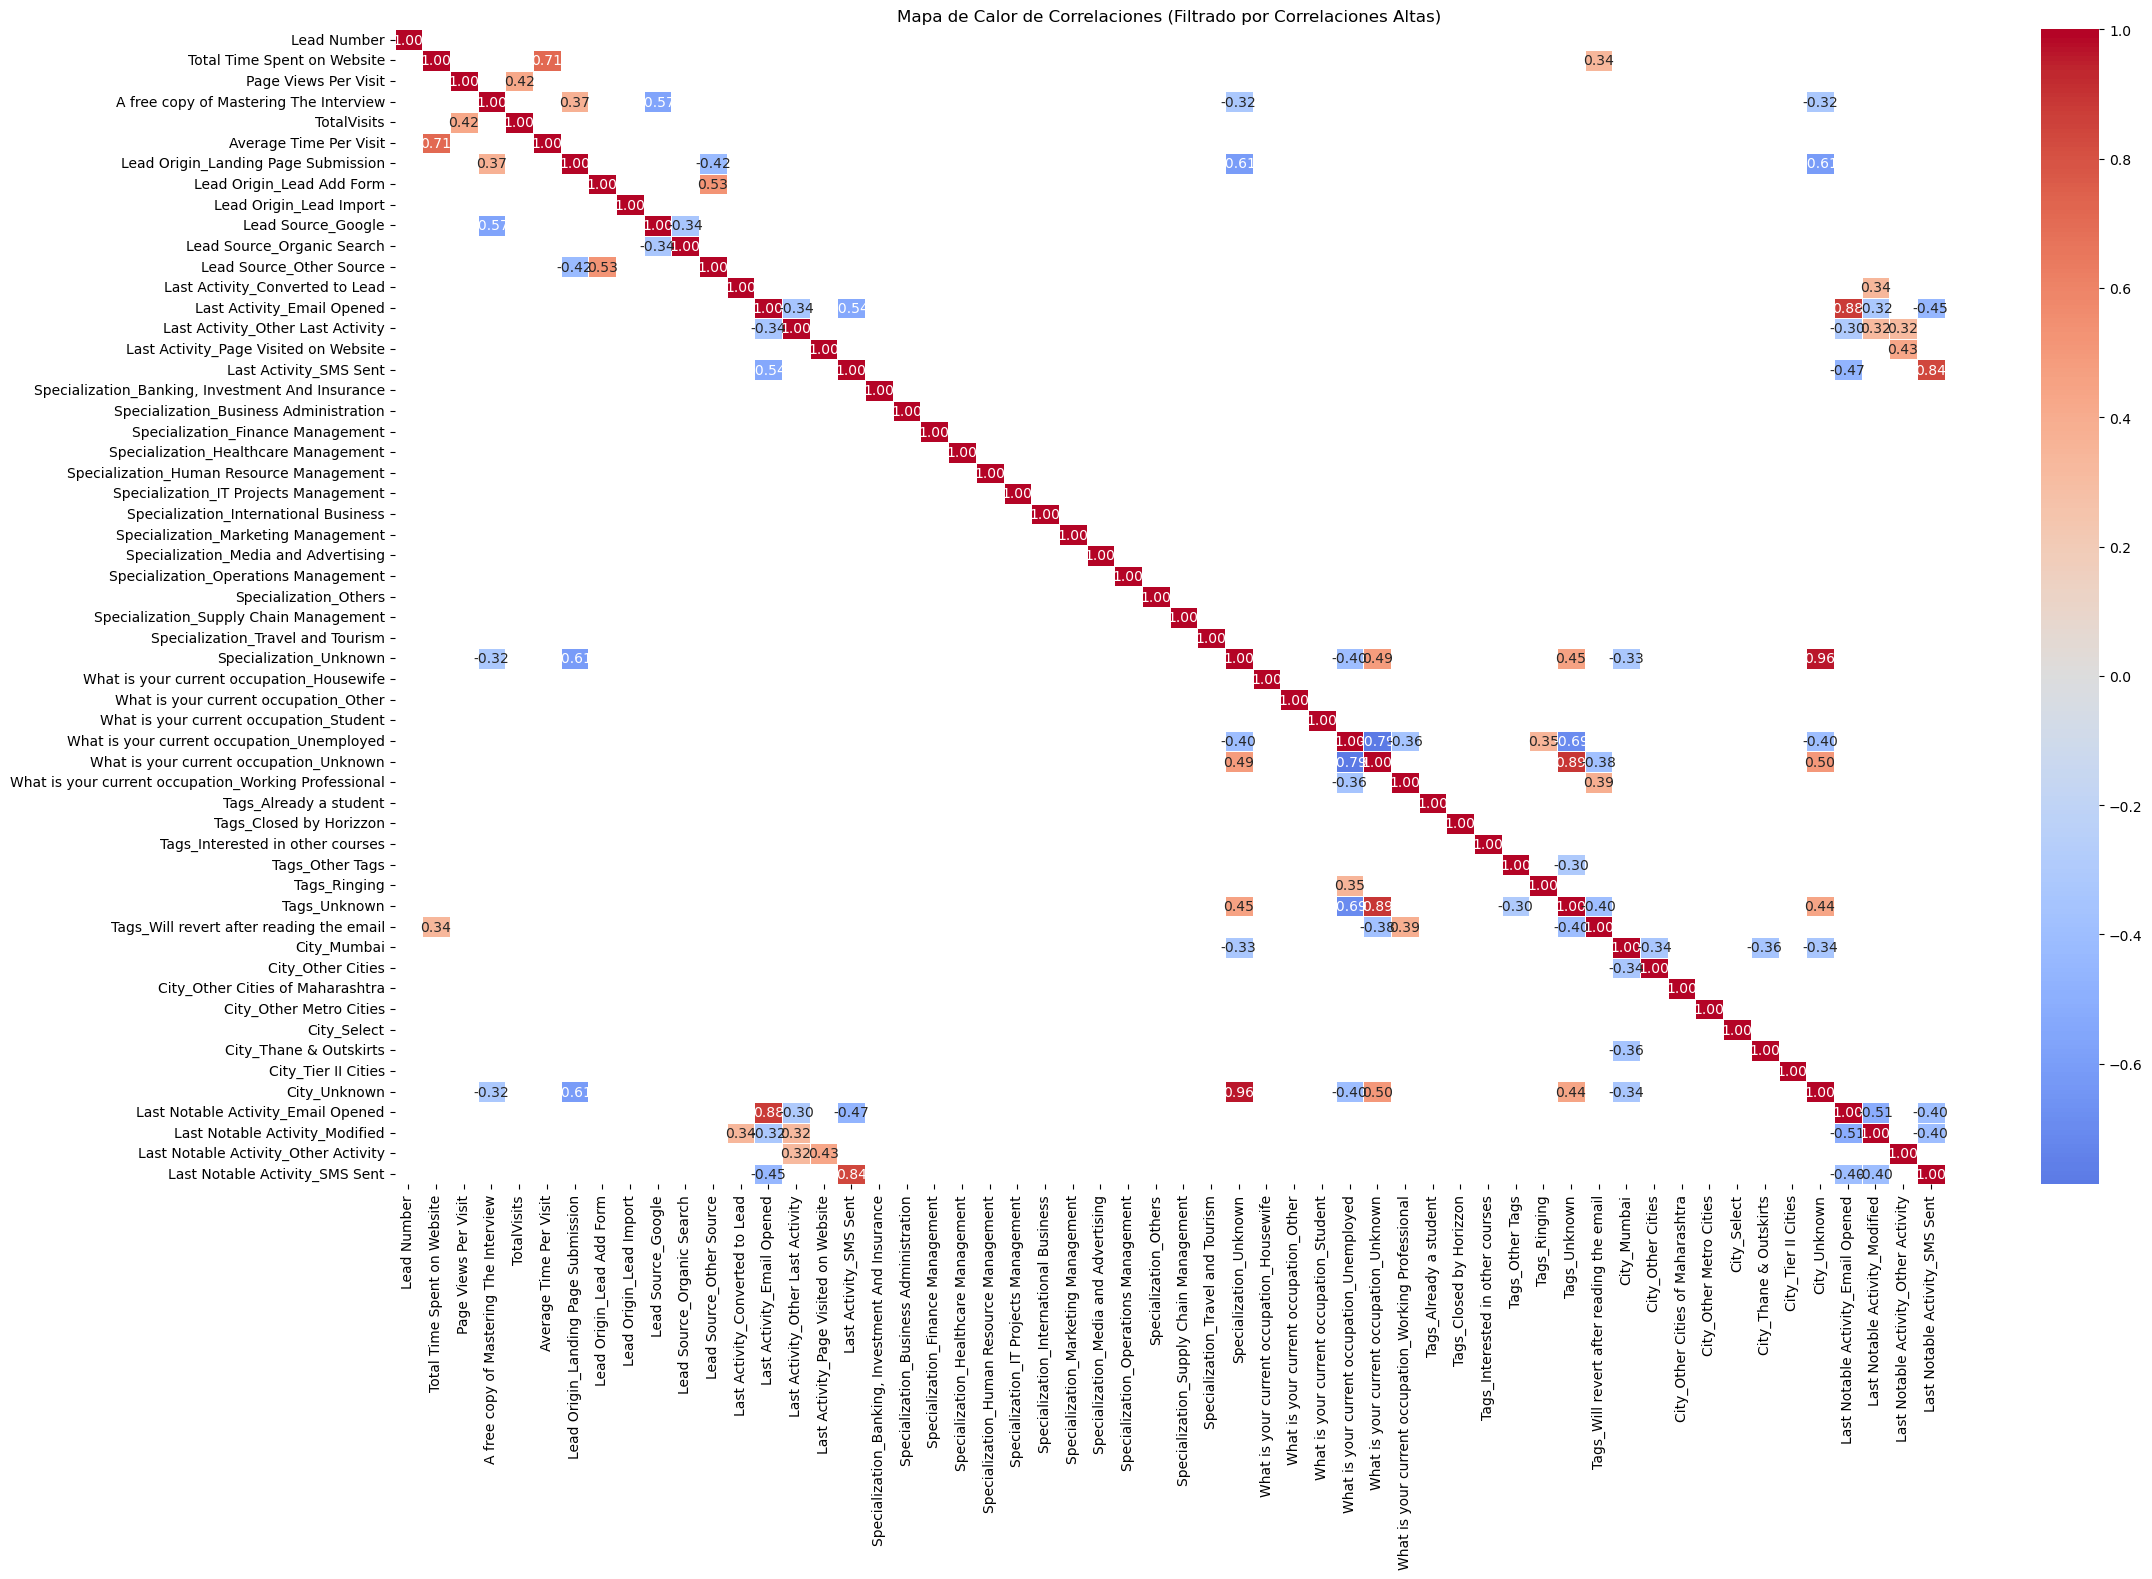

In [200]:
# Calcular la matriz de correlación
correlation_matrix = X_train.corr()

# Filtrar correlaciones altas (por encima de 0.3, ajusta según necesidad)
high_corr = correlation_matrix[(correlation_matrix > 0.3) | (correlation_matrix < -0.3)]

# Graficar el heatmap con anotaciones
plt.figure(figsize=(25, 15))
sns.heatmap(high_corr, annot=True, cmap='coolwarm', center=0, linewidths=0.5, fmt=".2f")

plt.title('Mapa de Calor de Correlaciones (Filtrado por Correlaciones Altas)')
plt.show()

## MODELO DE RANDOM FOREST ##

In [202]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split


# 2. Definir el modelo base (Random Forest)
model = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)

# 3. Inicializar RFE con Random Forest
rfe = RFE(estimator=model, n_features_to_select=20, step=5)  # step=5 elimina 5 features en cada iteración

# 4. Aplicar RFE a una muestra
X_sample, _, y_sample, _ = train_test_split(X_train, y_train, random_state=42)
rfe.fit(X_sample, y_sample)

# 5. Obtener features seleccionadas
selected_features = X_train.columns[rfe.support_]
print("Selected Features: ", selected_features)

# 6. Filtrar X_train y X_test con las mejores features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# 7. Entrenar Random Forest con features seleccionadas
final_model = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42)
final_model.fit(X_train_selected, y_train)

# 8. Evaluar el modelo
accuracy = final_model.score(X_test_selected, y_test)
print(f"Accuracy: {accuracy:.2f}")


Selected Features:  Index(['Lead Number', 'Total Time Spent on Website', 'Page Views Per Visit', 'A free copy of Mastering The Interview', 'TotalVisits', 'Average Time Per Visit', 'Last Activity_SMS Sent', 'What is your current occupation_Unemployed', 'What is your current occupation_Unknown', 'What is your current occupation_Working Professional', 'Tags_Already a student', 'Tags_Closed by Horizzon', 'Tags_Interested in other courses', 'Tags_Other Tags', 'Tags_Ringing', 'Tags_Unknown', 'Tags_Will revert after reading the email', 'City_Mumbai', 'Last Notable Activity_Modified', 'Last Notable Activity_SMS Sent'], dtype='object')
Accuracy: 0.86


Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predicciones
y_pred = final_model.predict(X_test_selected)

# Matriz de Confusión
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')

plt.title('Confusion Matrix for Random Forest Model')
plt.show()


ROC Curve

In [ ]:
from sklearn.metrics import roc_curve, auc

# Probabilidades de predicción
y_pred_proba = final_model.predict_proba(X_test_selected)[:, 1]

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest Model')
plt.legend(loc="lower right")
plt.show()


Precision-Recall Curve

In [ ]:
from sklearn.metrics import precision_recall_curve

# Calcular Precision-Recall
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_proba)

plt.figure()
plt.plot(recall, precision, color='green', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Random Forest Model')
plt.show()


Sensitivity, Specificity, and Accuracy vs Probability Threshold

In [ ]:
import numpy as np
import pandas as pd

# Calcular métricas para varios umbrales
thresholds = np.arange(0.0, 1.1, 0.1)
metrics_df = pd.DataFrame(columns=['Threshold', 'Accuracy', 'Sensitivity (Recall)', 'Specificity'])

for threshold in thresholds:
    y_pred_thresh = (y_pred_proba >= threshold).astype(int)
    cm = confusion_matrix(y_test, y_pred_thresh)
    
    TN, FP, FN, TP = cm.ravel()
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    
    metrics_df = metrics_df.append({
        'Threshold': threshold,
        'Accuracy': accuracy,
        'Sensitivity (Recall)': sensitivity,
        'Specificity': specificity
    }, ignore_index=True)

# Plotear métricas
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['Threshold'], metrics_df['Sensitivity (Recall)'], marker='o', label='Sensitivity (Recall)')
plt.plot(metrics_df['Threshold'], metrics_df['Specificity'], marker='s', label='Specificity')
plt.plot(metrics_df['Threshold'], metrics_df['Accuracy'], marker='^', label='Accuracy')

plt.xlabel('Probability Threshold')
plt.ylabel('Metric Value')
plt.title('Sensitivity, Specificity, and Accuracy vs Probability Threshold')
plt.legend()
plt.grid()
plt.show()
